<a href="https://colab.research.google.com/github/JSalazarAlt/QoT-predictions/blob/main/QoT_Predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **I. REGRESSION**

## **0. LIBRARIES IMPORTATION**

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import random
import sys


from sklearn.experimental import enable_halving_search_cv
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.model_selection import HalvingRandomSearchCV, GridSearchCV
from sklearn.metrics import max_error, mean_squared_error, mean_pinball_loss
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from contextlib import contextmanager

from itertools import chain
from pprint import pprint

## **1. READ DATASET**

### **1A. 'Read Dataset' Function Definition**

The function **read_dataset()** reads a file passed in input and returns three lists with lightpaths characteristics:
*   Matrix of span lengths.
*   Matrix of number of channels per link.
*   Vector of Signal-to-Noise Ratios (SNRs).







In [ ]:
def read_dataset(filename):

# Input:    - filename: Name of data file.
#
# Outputs:  - span_length_matrix: List with spans lengths for all the lightpaths (each element
#             of the list corresponds to one lightpath and is itself a list of variable len(),
#             depending on number of spans for lightpath).
#           - channels_link_matrix: List with number of channels per link info (each element of
#             the list corresponds to one link along the path).
#           - SNR_vect: List of SNR values for each lightpath [dB].

    # INITIALIZATION

    # Matrix for span lengths (in Km) along the path
    span_length_matrix = []

    # Matrix for the number of channels per link
    channels_link_matrix = []

    # Vector for SNR values (dB) at the receiver
    SNR_vect = []

    # INFORMATION RECOVERY

    with open(filename) as data_file:

        next(data_file)

        for line in data_file: #F: line will scan through each lightpath

            # Split the line in the file to recover the three pieces of information:
            # spans lengths, number of channels per link, and SNR
            elements = line.split(';', 3)

            # Recover spans information as a list of strings
            spans = elements[0]
            spans_list = spans.split(',')

            # Store spans information as a vector of integers and add it to the spans matrix
            span_lengths_vect = []
            span_lengths_vect = [int(spans_list[i]) for i in range(len(spans_list))]

            span_length_matrix.append(span_lengths_vect)

            # Recover number of channels per link as a list of strings
            channels_link = elements[1]
            channels_link = channels_link.split(',')

            # Store number of channels as a vector of integers and add it to the number of channels matrix
            channels_link_vect = []
            channels_link_vect = [int(channels_link[i]) for i in range(len(channels_link))]

            channels_link_matrix.append(channels_link_vect)

            # Recover the SNR as a list of floats and add
            snr = float(elements[2])
            SNR_vect.append(snr)

    return span_length_matrix, channels_link_matrix, SNR_vect


### **1B. 'Read Dataset' Function Call and Statistics Computation**

Call the function **read_dataset()** using the corresponding input file. Then, the dimensions of the returned values are checked, and the statistics (mean, variance, and standard deviation) are computed and printed for all paths for the following features:
*   Number of spans along the path.
*   Total lightpath (total span) length.
*   Maximum number of channels per link.
*   SNR.

In [ ]:
# READ DATAFILE AND LENGTH CHECK

# Path of the datafiles
datafile_german = "/content/drive/MyDrive/NDA/Final_project/Dataset_german_17_node.dat"
datafile_european = "/content/drive/MyDrive/NDA/Final_project/Dataset_european_19_node.dat"

# Read datafiles to get the information
spans_german, channels_link_german, snr_values_german = read_dataset(datafile_german);
spans_european, channels_link_european, snr_values_european = read_dataset(datafile_european);

# Gather together the data extracted from both files
spans = []
channels_link = []
snr_values = []

for span in spans_german:
    spans.append(span)
for channels in channels_link_german:
    channels_link.append(channels)
for snr in snr_values_german:
    snr_values.append(snr)

# Check the length of the matrixes and target vector
print('Length of Spans list: {}'.format(str(len(spans))))
print('Length of Channels per link list: {}'.format(str(len(channels_link))))
print('Length of SNR list: {}'.format(str(len(snr_values))))

# STATISTICS COMPUTATION

# 1. Statistics from Spans matrix

# Recover the total lightpath (or span) lenght per every row in the matrix
numspans = []
lightpathlength = []
for i in range(len(spans)):
    numspans.append(len(spans[i]))
    lightpathlength.append(sum(spans[i]))

# 1a. Mean, variance, and standard deviation of the number of spans
mean_numspans = round(sum(numspans)/len(numspans), 2)
var_numspans = round(sum([((x - mean_numspans) ** 2) for x in numspans])/len(numspans), 2)
std_numspans = round(var_numspans**0.5, 2)

# 1b. Mean, variance, and standard deviation of the number of spans
mean_lightpathlength = round(sum(lightpathlength)/len(lightpathlength), 2)
var_lightpathlength = round(sum([((x - mean_lightpathlength) ** 2) for x in lightpathlength])/len(lightpathlength), 2)
std_lightpathlength = round(var_lightpathlength**0.5, 2)

# 2. Statistics from Channels per link matrix

maxnuminterf = [max(channels_link[i]) for i in range(len(channels_link))]

# 2a. Mean, variance, and standard deviation of the number of channels per link
mean_maxnuminterf = round(sum(maxnuminterf)/len(maxnuminterf), 2)
var_maxnuminterf = round(sum([((x - mean_maxnuminterf) ** 2) for x in maxnuminterf])/len(maxnuminterf), 2)
std_maxnuminterf = round(var_maxnuminterf**0.5, 2)

# 3. Statistics from SNR vector

mean_snr = round(sum(snr_values)/len(snr_values), 2)
var_snr = round(sum([((x - mean_snr) ** 2) for x in snr_values])/len(snr_values), 2)
std_snr = round(var_snr**0.5, 2)

print('\n**************************************\n')
print('Number of Spans: mean = {}, var = {}, std = {}'.format(mean_numspans, var_numspans, std_numspans))
print('Lightpath Length: mean = {}, var = {}, std = {}'.format(mean_lightpathlength, var_lightpathlength, std_lightpathlength))
print('Number of Channels per Link: mean = {}, var = {}, std = {}'.format(mean_maxnuminterf, var_maxnuminterf, std_maxnuminterf))
print('SNR: mean = {}, var = {}, std = {}'.format(mean_snr, var_snr, std_snr))


Length of Spans list: 1672
Length of Channels per link list: 1672
Length of SNR list: 1672

**************************************

Number of Spans: mean = 7.19, var = 9.67, std = 3.11
Lightpath Length: mean = 439.98, var = 38192.79, std = 195.43
Number of Channels per Link: mean = 25.44, var = 163.06, std = 12.77
SNR: mean = 15.67, var = 1.65, std = 1.28


## **2. FEATURES EXTRACTION**


### **2A. 'Extract Features' Function Definition**

The function **extract_features()** takes in input the lists of features (i.e., excluding SNR) obtained in section 1B and returns a numpy array including the features as columns. In this case, the following 8 features are extracted:
1.   Number of fiber spans along the path.
2.   Total lightpath length.
3.   Longest fiber span length (between 2 amplifiers).
4.   Maximum number of channels per link.
5.   Minimum number of channels per link.
6.   Mean number of channels per link.
7.   Number of links along the path.
8.   Total number of channels along the path.



In [ ]:
def extract_features(span_matrix, channels_link_matrix):

# Inputs:    - span_matrix: Matrix (list) of spans for each lightpath as returned by function
#              read_dataset().
#            - channels_link_matrix: Matrix (list) of channel per link info (number of channels
#              per link) as returned by function read_dataset().
#
# Output:    - numpy array X_matrix:  Array containing the following features (one row for each lightpath):
#                1) Number of fiber spans along the path
#                2) Total lightpath length
#                3) Longest fiber span length (between 2 amplifiers)
#                4) Maximum number of channels per link
#                5) Minimum number of channels per link
#                6) Mean number of channels per link
#                7) Number of links along the path
#                8) Total number of channels along the path

    # INITIALIZATION

    # Array to return
    X_matrix = []

    # FEATURE EXTRACTION

    for span_len_vect, channels_link_vect in zip(span_matrix, channels_link_matrix):

        feature_vect = []

        # Extraction of features from span vector
        feature_vect.append(len(span_len_vect))
        feature_vect.append(sum(span_len_vect))
        feature_vect.append(max(span_len_vect))

        # Extraction of features from number of channels per link vector
        feature_vect.append(max(channels_link_vect))
        feature_vect.append(min(channels_link_vect))
        feature_vect.append(np.mean(channels_link_vect))
        feature_vect.append(len(channels_link_vect))
        feature_vect.append(sum(channels_link_vect))

        # Add feature vetor to the array
        X_matrix.append(feature_vect)

    return np.array(X_matrix)


### **2B. 'Extract Features' Function Call and Features Statistics Computation**

Call the function **extract_features()** using the lists of spans and channels per link obtained in section 1B. Then, the dimension of the returned array is checked, and the statistics (mean, variance, and standard deviation) are computed and printed for all features.

*Reference:*
*   https://numpy.org/doc/stable/reference/routines.statistics.html


In [ ]:
# FEATURES EXTRACTION

# Extraction of features and print shape of the array
X = extract_features(spans, channels_link)
print('Shape of features matrix: ' + str(X.shape))
print('\n***********************************\n')

# FEATURES STATISTICS

# 1. Number of spans
ns = [X[i][0] for i in range(X.shape[0])]
mean_ns = round(np.mean(ns), 2)
var_ns = round(np.var(ns), 2)
std_ns = round(np.std(ns), 2)
print('Number of spans: mean = {}, var = {}, std = {}'.format(mean_ns, var_ns, std_ns))

# 2. Lightpath (total span) length
ll = [X[i][1] for i in range(X.shape[0])]
mean_ll = round(np.mean(ll), 2)
var_ll = round(np.var(ll), 2)
std_ll = round(np.std(ll), 2)
print('Lightpath length: mean = {}, var = {}, std = {}'.format(mean_ll, var_ll, std_ll))

# 3. Longest span length
ls = [X[i][2] for i in range(X.shape[0])]
mean_ls = round(np.mean(ls), 2)
var_ls = round(np.var(ls), 2)
std_ls = round(np.std(ls), 2)
print('Longest span length: mean = {}, var = {}, std = {}'.format(mean_ls, var_ls, std_ls))

# 4. Maximum number of channels per link
ni = [X[i][3] for i in range(X.shape[0])]
mean_ni = round(np.mean(ni), 2)
var_ni = round(np.var(ni), 2)
std_ni = round(np.std(ni), 2)
print('Maximum number of channels per link: mean = {}, var = {}, std = {}'.format(mean_ni, var_ni, std_ni))

# 5. Minimum number of channels per link
ni = [X[i][4] for i in range(X.shape[0])]
mean_ni = round(np.mean(ni), 2)
var_ni = round(np.var(ni), 2)
std_ni = round(np.std(ni), 2)
print('Minimum number of channels per link: mean = {}, var = {}, std = {}'.format(mean_ni, var_ni, std_ni))

# 6. Mean number of channels per link
ni = [X[i][5] for i in range(X.shape[0])]
mean_ni = round(np.mean(ni), 2)
var_ni = round(np.var(ni), 2)
std_ni = round(np.std(ni), 2)
print('Mean number of channels per link: mean = {}, var = {}, std = {}'.format(mean_ni, var_ni, std_ni))

# 7. Number of links along the path
ni = [X[i][6] for i in range(X.shape[0])]
mean_ni = round(np.mean(ni), 2)
var_ni = round(np.var(ni), 2)
std_ni = round(np.std(ni), 2)
print('Number of links along the path: mean = {}, var = {}, std = {}'.format(mean_ni, var_ni, std_ni))

# 8. Total number of channels along the path
ni = [X[i][7] for i in range(X.shape[0])]
mean_ni = round(np.mean(ni), 2)
var_ni = round(np.var(ni), 2)
std_ni = round(np.std(ni), 2)
print('Total number of channels along the path: mean = {}, var = {}, std = {}'.format(mean_ni, var_ni, std_ni))


Shape of features matrix: (1672, 8)

***********************************

Number of spans: mean = 7.19, var = 9.67, std = 3.11
Lightpath length: mean = 439.98, var = 38192.79, std = 195.43
Longest span length: mean = 72.51, var = 77.7, std = 8.81
Maximum number of channels per link: mean = 25.44, var = 163.06, std = 12.77
Minimum number of channels per link: mean = 10.31, var = 55.09, std = 7.42
Mean number of channels per link: mean = 17.62, var = 79.9, std = 8.94
Number of links along the path: mean = 3.08, var = 1.97, std = 1.4
Total number of channels along the path: mean = 59.03, var = 2126.51, std = 46.11


### **2C. Features Distribution Plot**

Scatterplots with distribution of SNR values against each of the features are drawn. These scatterplots are helpful in other to see the dependance of the SNR values against each of the features and have a better idea of the relevance of the features for the regression or classification model.

Saved combined plot to /content/drive/MyDrive/NDA/Final_project/Images/German_dataset/German_dataset_combined_plot.png


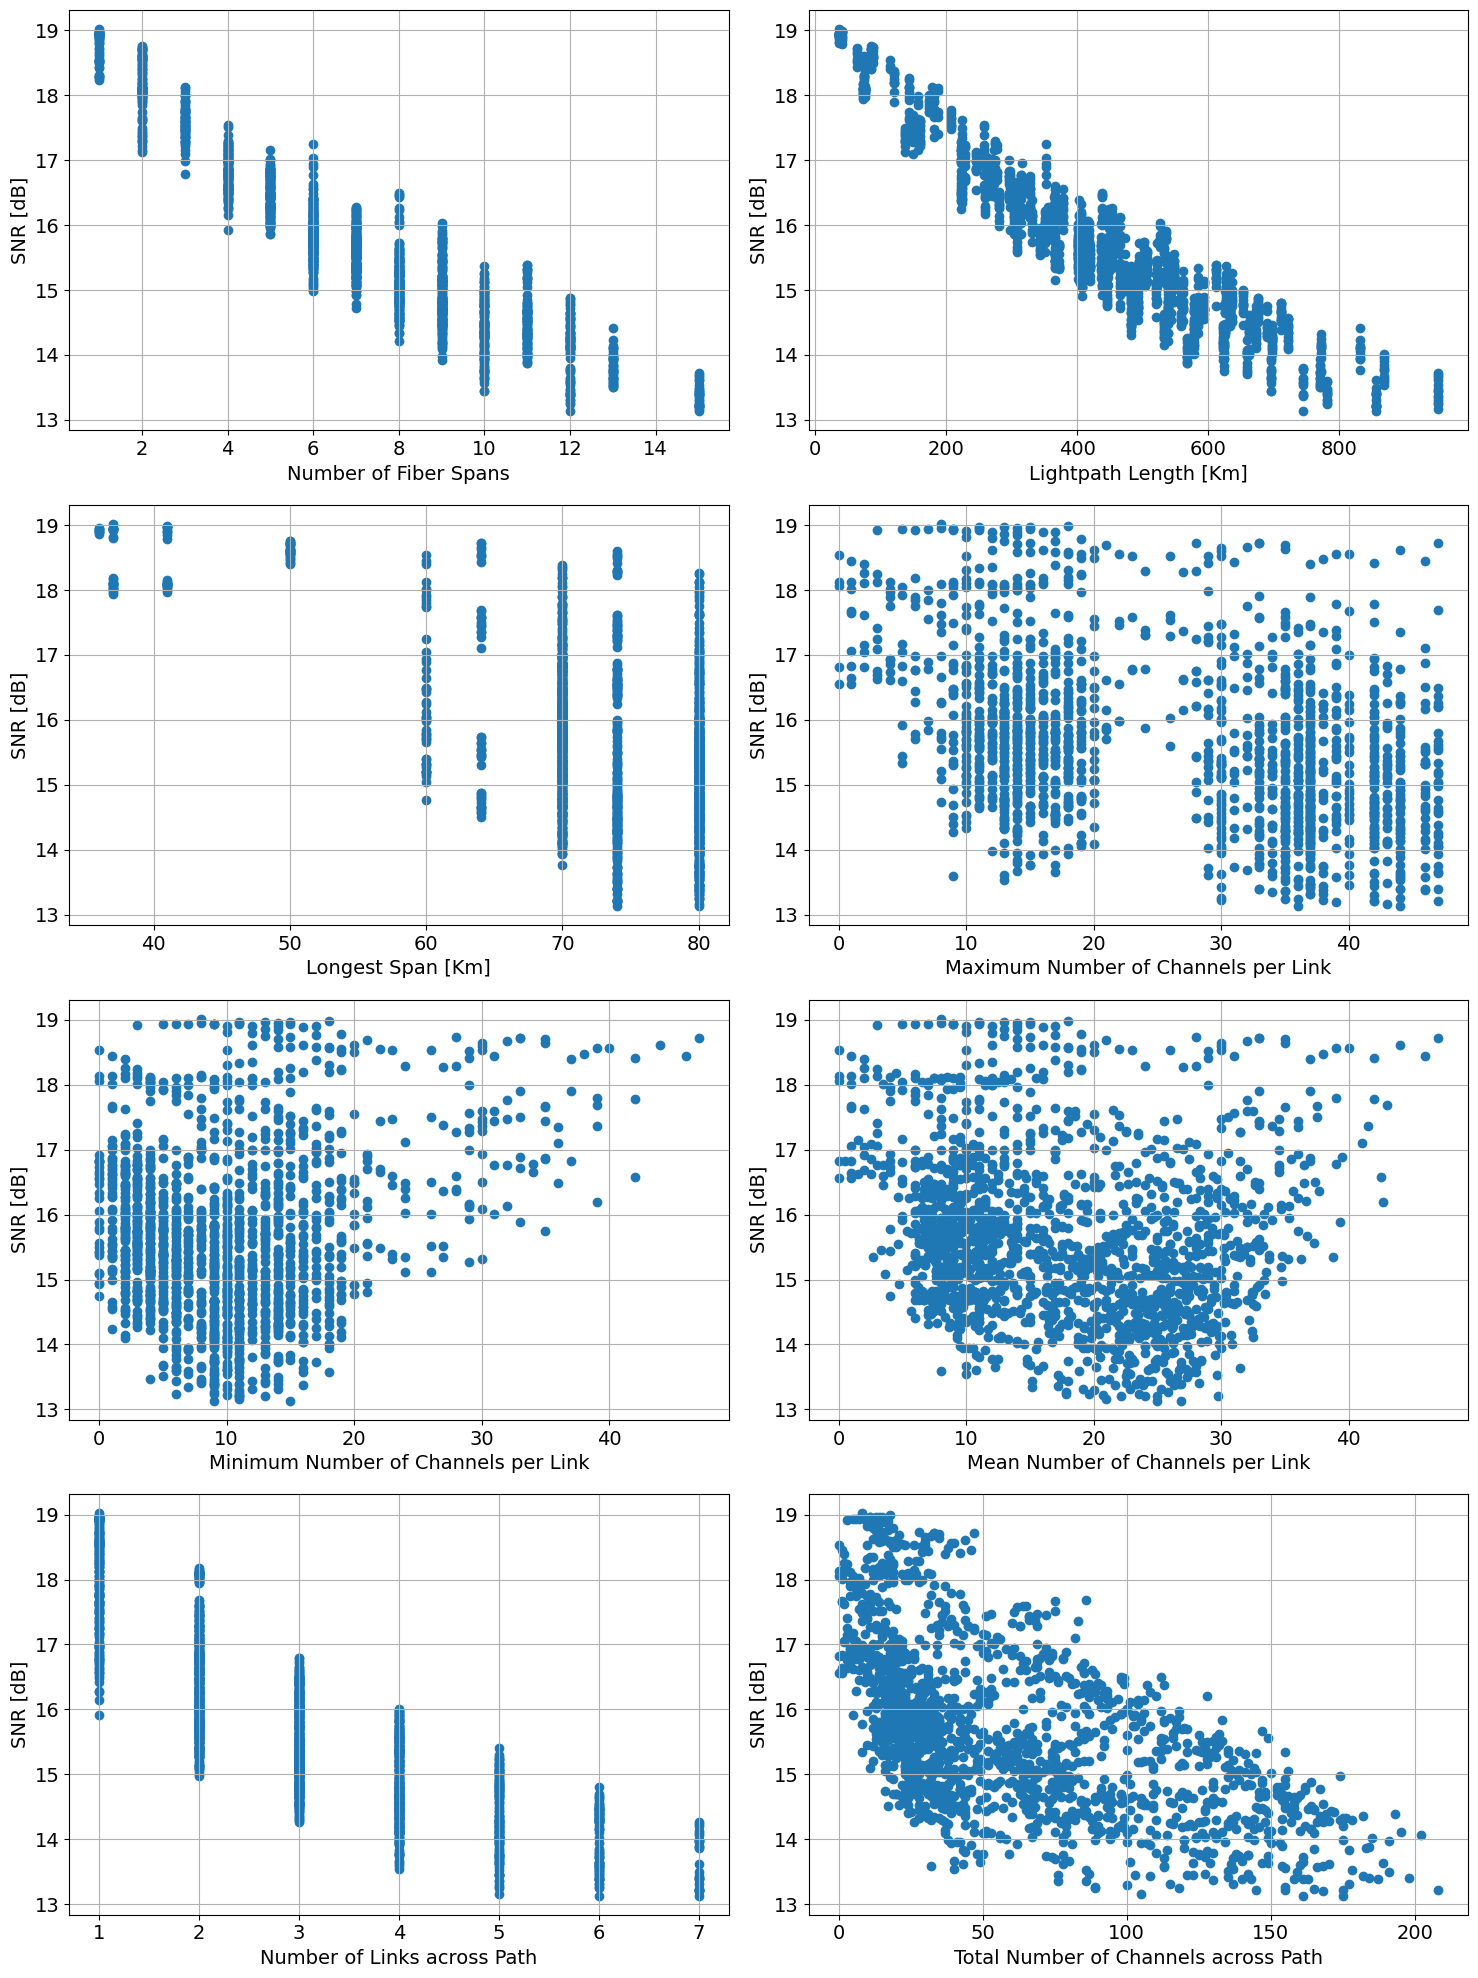

In [ ]:
# Specify the folder in Google Drive where to save the plots
drive_folder = '/content/drive/MyDrive/NDA/Final_project/Images/German_dataset'

# Create the folder if it does not exist
os.makedirs(drive_folder, exist_ok = True)

# Figure settings to improve readability
FONT_SIZE = 14
plt.rc('font', size = FONT_SIZE)         # Control default text sizes
plt.rc('axes', titlesize = FONT_SIZE)    # Fontsize of the axes title
plt.rc('axes', labelsize = FONT_SIZE)    # Fontsize of the x and y labels
plt.rc('xtick', labelsize = FONT_SIZE)   # Fontsize of the tick labels
plt.rc('ytick', labelsize = FONT_SIZE)   # Fontsize of the tick labels
plt.rc('legend', fontsize = 12)          # Legend fontsize
plt.rc('figure', titlesize = FONT_SIZE)  # Fontsize of the figure title

# List of feature names for labeling
feature_names = [ 'Number of Fiber Spans',
                  'Lightpath Length [Km]',
                  'Longest Span [Km]',
                  'Maximum Number of Channels per Link',
                  'Minimum Number of Channels per Link',
                  'Mean Number of Channels per Link',
                  'Number of Links across Path',
                  'Total Number of Channels across Path' ]

# Create a figure with subplots with 4 rows and 2 columns
fig, axs = plt.subplots(4, 2, figsize=(15, 20))

# Generate and save plots in subplots
for i, ax in enumerate(axs.flatten()):
    ax.scatter(X[:, i], snr_values)
    ax.set_xlabel(feature_names[i])
    ax.set_ylabel('SNR [dB]')
    ax.grid()

plt.tight_layout()

# Save the combined image
file_name = 'German_dataset_combined_plot.png'
file_path = os.path.join(drive_folder, file_name)
plt.savefig(file_path)
print(f"Saved combined plot to {file_path}")

plt.show()


## **3. TREE REGRESSION MODEL**

### **3A. Training and Test Sets Split**

The dataset is split into training set (80 %) and test set (20 %). Therefore, the features array **X** and the labels array (target SNR values) **y** are divided into two subarrays correspondingly: **X_train**, **X_test**, **y_train**, and **y_test**.

In [ ]:
# DATASET SPLIT

# Convert the SNR list to an array
y = np.array(snr_values)

# Dataset split into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, random_state = 0)

# Saving original X_train and X_test datasets without normalization
X_train_wo_norm = X_train.copy()
X_test_wo_norm = X_test.copy()

# Normalize the training and test datasets according to the training set statistics
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


### **3B. 'Optimize GBR Hyperparameters' Function Definition**

The function **optimize_GBR()** takes in input the training features array **X_train**, the training labels **y_train**, and the quantile **α**, and returns the best set of hyperparameters that fit the inputs. This function performs two tasks:
*   **Hyperparameters Optimization:** Obtain the best combination of hyperparameters that fit inputs for the specific Gradient Boosting Regressor (GBR) model.
*   **Cross Validation:** Split in the training set into 5 folds (`cv = 5`) to average the performance across all the folds to get a more robust estimate of how well the model performs on unseen data.

Be aware that both tasks are performed using the *GridSearchCV* from *sklearn.model_selection*.

Reference:
*   https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html#tuning-the-hyper-parameters-of-the-quantile-regressors
*   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [ ]:
def optimize_GBR(X_train, y_train, alpha):

# Inputs:   - X_train: Array of features of the training dataset
#           - y_train: Array of SNR labels of the training set
#           - alpha: Alpha parameter
#
# Output:   - best_params: Dictionary of best hyperparameters

    # HYPERPARAMETERS SPACE, MODEL, AND SCORER DEFINITION

    # Define the initial grid of hyperparameters values to test
    initial_param_grid = { 'learning_rate': [0.05, 0.1, 0.2],
                           'n_estimators': [100, 200, 500],
                           'max_depth': [2, 5, 10],
                           'min_samples_leaf': [1, 5, 10, 20],
                           'min_samples_split': [5, 10, 20, 30] }

    # Define the reduced grid of hyperparameters values to test
    param_grid = { 'learning_rate': [0.2],
                   'n_estimators': [100, 200, 500],
                   'max_depth': [2],
                   'min_samples_leaf': [5, 10],
                   'min_samples_split': [20, 30] }

    # Build the scorer for maximizing the negative loss
    neg_mean_pinball_loss_scorer = make_scorer(
        mean_pinball_loss,
        alpha = alpha,
        greater_is_better = False,  # Maximize the negative loss
    )

    # Define Gradient Boosting Regressor model
    gbr = GradientBoostingRegressor(loss = "quantile", alpha = alpha, random_state = 0)

    # HYPERPARAMETERS OPTIMIZATION AND CROSS VALIDATION

    # Run the hyperparameter optimization and cross validation for alpha
    grid_search = GridSearchCV (estimator = gbr, param_grid = param_grid, cv = 5, \
                                scoring = neg_mean_pinball_loss_scorer, n_jobs = 2)

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    # Get the best set of hyperparameters
    best_params = grid_search.best_params_

    #print("Best parameters found: {}".format(best_params))

    return best_params


### **3C. 'Train Gradient Boosting Regressor' Function Definition**

The function **train_GBR()** takes in input the training dataset (features and labels) and the alpha parameter, then it performs three main tasks:
*   **Hyperparameter Optimization and Cross Validation:** Call the **optimize_GBR()** function to perform the hyperparameters optimization and cross validation.
*   **Model Training:** Train a Gradient Boosting Regressor (GBR) model. For the model, we use *GradientBoostingRegressor* from *sklearn.ensemble*.
*   **Performance Metrics Evaluation:** Provide the training results in terms of performance metrics. In this case, we use as performance metrics the R2 score, the Mean Squared Error (MSE), and the Mean Pinball Loss (MPL).

Documentation and background at:
*   https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_quantile.html

In [ ]:
def train_GBR(X_train, y_train, alpha):

# Inputs:   - X_train: Array of features of the training dataset
#           - y_train: Array of SNR labels of the training set
#
# Output:   - model: Trained GBR model
#           - training_time: Measured training time for fitting the model

    # HYPERPARAMETER OPTIMIZATION AND CROSS VALIDATION

    # Get the best combination of hyperparameters values to train
    best_params = optimize_GBR(X_train, y_train, alpha)

    # MODEL TRAINING

    # Train the GBR model
    t0 = time.time()
    gbr = GradientBoostingRegressor(loss = "quantile", alpha = alpha, **best_params)
    model = gbr.fit(X_train, y_train)
    t1 = time.time()

    # Get the training time
    training_time = round(t1-t0, 3)

    # Predict the output values for the training set
    yhat_GBR_train = model.predict(X_train)

    # PERFORMANCE METRICS EVALUATION

    # Compute the performance metrics
    r2 = model.score(X_train, y_train)
    mse = mean_squared_error(y_train, yhat_GBR_train)
    mpl = mean_pinball_loss(y_train, yhat_GBR_train, alpha = alpha)

    # Print the performance metrics
    print('Training time [s]: ' + str(training_time))
    print('Final training R2 score is: ' + str(round(r2, 3)))
    print('Final training Mean Squared Error (MSE) is: ' + str(round(mse, 3)))
    print('Final training Mean Pinball Loss (MPL) is: ' + str(round(mpl, 3)))

    return model, training_time


### **3D. 'Train Gradient Boosting Regressor' Function Call**

Call the function **train_GBR()** using as inputs the training features array **X_train**, the training labels array **y_train**, and the percentile **α**. After the function call, the performance metrics of the model (R2 score, MSE, and MPL) are displayed in the cell output.

In [ ]:
# Define a value of alpha
alpha = 0.10

# Call the function to train the model
GBR, train_duration = train_GBR(X_train, y_train, alpha)

Training time [s]: 0.767
Final training R2 score is: 0.946
Final training Mean Squared Error (MSE) is: 0.088
Final training Mean Pinball Loss (MPL) is: 0.027


### **3E. Performance Metrics Evaluation for Training and Test Sets**

Display the performance metrics (R2 score, MSE, and MPL) for Gradient Boosting Regression in both cases, for training and test sets.

In [ ]:
# PERFORMANCE METRICS EVALUATION

# Performance metrics evaluation for training set
r2_GBR_train = GBR.score(X_train, y_train)
yhat_GBR_train = GBR.predict(X_train)
mse_GBR_train = mean_squared_error(y_train, yhat_GBR_train)
mpl_GBR_train = mean_pinball_loss(y_train, yhat_GBR_train, alpha=alpha)

print('********** TRAINING SCORES **********\n')
print('Gradient Boosting Regression')
print('Final training R2 score is: ' + str(round(r2_GBR_train, 3)))
print('Final training MSE is: ' + str(round(mse_GBR_train, 3)))
print('Final training MPL is: ' + str(round(mpl_GBR_train, 3)))

# Performance metrics evaluation for test set
r2_GBR_test = GBR.score(X_test, y_test)
yhat_GBR_test = GBR.predict(X_test)
mse_GBR_test = mean_squared_error(y_test, yhat_GBR_test)
mpl_GBR_test = mean_pinball_loss(y_test,yhat_GBR_test, alpha=alpha)

print('\n********** TEST SCORES **************\n')
print('Gradient Boosting Regression')
print('Final test R2 score is: ' + str(round(r2_GBR_test, 3)))
print('Final test MSE is: ' + str(round(mse_GBR_test, 3)))
print('Final test MPL is: ' + str(round(mpl_GBR_test, 3)))

********** TRAINING SCORES **********

Gradient Boosting Regression
Final training R2 score is: 0.946
Final training MSE is: 0.088
Final training MPL is: 0.027

********** TEST SCORES **************

Gradient Boosting Regression
Final test R2 score is: 0.936
Final test MSE is: 0.11
Final test MPL is: 0.034


### **3F. SNR Overestimations and Underestimations for Training and Test Sets**

Compute the SNR overestimations and underestimations to check if the distribution follows the quantile specified in section 3D.

In [ ]:
# Computation of overestimations and underestimations for training set
delta_y_train = yhat_GBR_train - y_train
delta_y_train_over = np.where(delta_y_train > 0)[0].tolist()
delta_y_train_under = np.where(delta_y_train < 0)[0].tolist()

total_SNR_train = len(delta_y_train)
num_overrated_SNR_train = len(delta_y_train_over)
num_underrated_SNR_train = len(delta_y_train_under)

percentage_overrated_SNR_train = round(100*(num_overrated_SNR_train/total_SNR_train), 2)
percentage_underrated_SNR_train = round(100*(num_underrated_SNR_train/total_SNR_train), 2)

print('******* TRAINING SNR OVER/UNDER-ESTIMATIONS *******\n')
print('Out of {} paths: '.format(total_SNR_train))
print(' - Number of overrated SNRs: {} ({} %)'.format(num_overrated_SNR_train, \
                                                      percentage_overrated_SNR_train))
print(' - Number of underrated SNRs: {} ({} %)'.format(num_underrated_SNR_train, \
                                                       percentage_underrated_SNR_train))

# Computation of overestimations and underestimations for test set
delta_y_test = yhat_GBR_test - y_test
delta_y_test_over = np.where(delta_y_test > 0)[0].tolist()
delta_y_test_under = np.where(delta_y_test < 0)[0].tolist()

total_SNR_test = len(delta_y_test)
num_overrated_SNR_test = len(delta_y_test_over)
num_underrated_SNR_test = len(delta_y_test_under)

percentage_overrated_SNR_test = round(100*(num_overrated_SNR_test/total_SNR_test), 2)
percentage_underrated_SNR_test = round(100*(num_underrated_SNR_test/total_SNR_test), 2)

print('\n********* TEST SNR OVER/UNDER-ESTIMATIONS *********\n')
print('Out of {} paths: '.format(total_SNR_test))
print(' - Number of overrated SNRs: {} ({} %)'.format(num_overrated_SNR_test, \
                                                      percentage_overrated_SNR_test))
print(' - Number of underrated SNRs: {} ({} %)'.format(num_underrated_SNR_test, \
                                                       percentage_underrated_SNR_test))


******* TRAINING SNR OVER/UNDER-ESTIMATIONS *******

Out of 1337 paths: 
 - Number of overrated SNRs: 135 (10.1 %)
 - Number of underrated SNRs: 1202 (89.9 %)

********* TEST SNR OVER/UNDER-ESTIMATIONS *********

Out of 335 paths: 
 - Number of overrated SNRs: 28 (8.36 %)
 - Number of underrated SNRs: 307 (91.64 %)


## **4. LABELS CONVERSION AND INCORRECT ASSIGNMENTS COMPUTATION**

### **4A. 'SNR to Modulation Format' Function Definition**

The function **SNR_to_MF()** takes in input SNR value and uses it to return the highest possible modulation format (MF).
According to the information provided, the required SNR to have certain modulations are:
*   QPSK:  SNR = 8.7
*   8QAM:  SNR = 12.8
*   16QAM: SNR = 15.2
*   32QAM: SNR = 18.2
*   64QAM: SNR = 21.0

In [ ]:
def SNR_to_MF(SNR):

# Input:    - SNR: SNR value (predicted or ground truth) used to decide Modulation Format (MF)
#
# Output:   - Order of the highest configurable MF; return a number corresponding to the MF:
#             4 (QPSK), 8 (8QAM), 16 (16QAM), 32 (32QAM), 64 (64QAM)

# Be aware that we use "<" and ">" instead of "<=" and ">=", as SNR is a float and floats
# cannot be compared using equality

    if SNR < 8.7:
        return 0

    elif SNR > 8.7 and SNR < 12.8:
        return 4

    elif SNR > 12.8 and SNR < 15.2:
        return 8

    elif SNR > 15.2 and SNR < 18.2:
        return 16

    elif SNR > 18.2 and SNR < 21.0:
        return 32

    else:
        return 64

### **4B. 'Modulation Format Errors' Function Definition**

The **find_MF_errors()** takes in input the arrays of ground truth labels and predicted labels, and returns the corresponding ground truth and predicted lists of modulation formats (MF) for the inputs, and the number of overestimations and underestimations.

In [ ]:
def find_MF_errors(SNR_true_vect, SNR_pred_vect):

# Inputs:   - SNR_true_vect: Array of ground truth SNR values
#           - SNR_pred_vect: Array of predicted SNR values
#
# Outputs:  - MF_true: List of ground truth MF values
#           - MF_predicted: List of predicted MF values
#           - num_total_MF: Number of incorrectly-assigned MF
#           - num_overrated_MF: Number of MF overestimations
#           - num_underrated_MF: Number of MF overestimations

    # INITIALIZATION

    num_diff_MF = 0
    num_overrated_MF = 0
    num_underrated_MF = 0

    MF_predicted = []
    MF_true = []

    num_total_MF = len(SNR_true_vect)

    # INCORRECT MF ASSIGNMENT COMPUTATION

    for i in range(len(SNR_true_vect)):

        # Store the corresponding modulation format for a true/predicted SNR
        MF_predicted.append(SNR_to_MF(SNR_pred_vect[i]))
        MF_true.append(SNR_to_MF(SNR_true_vect[i]))

        # Compute the number of overestimations and underestimations
        if SNR_to_MF(SNR_pred_vect[i]) != SNR_to_MF(SNR_true_vect[i]):

            if SNR_to_MF(SNR_pred_vect[i]) > SNR_to_MF(SNR_true_vect[i]):
                num_overrated_MF = num_overrated_MF + 1
            else:
                num_underrated_MF = num_underrated_MF + 1

    num_incorrect_MF = num_overrated_MF + num_underrated_MF
    percentage_incorrect_MF = round(100*(num_incorrect_MF/num_total_MF), 2)

    print('\nOut of {} MF assignments: '.format(num_total_MF))
    print(' - Number of incorrectly-assigned MFs: {} ({} %)'.format(num_incorrect_MF, percentage_incorrect_MF))
    print(' - Number of overrated MFs: {}'.format(num_overrated_MF))
    print(' - Number of underrated MFs: {}'.format(num_underrated_MF))

    return MF_true, MF_predicted, num_incorrect_MF, num_overrated_MF, num_underrated_MF


### **4C. 'Modulation Format Errors' Function Call**

Call **find_MF_errors()** using the arrays of ground truth SNR **y_train** and the array of predicted SNR **yhat_GBR_train**. Finally, since the function also return the list of corresponding modulations formats (MF) for the inputs, the confusion matrix is displayed.

In [ ]:
# Predict the values for the train set
yhat_GBR_train = GBR.predict(X_train)

# Compute incorrect assignments of MF
print('******* TRAINING MF OVER/UNDER-ESTIMATIONS *******')
MF_train, MF_reg_predicted_train, _ , _ , _ = find_MF_errors(y_train, yhat_GBR_train)

# Predict the values for the test set
yhat_GBR_test = GBR.predict(X_test)

# Compute the incorrect MF assignments for the test set
print('\n********* TEST MF OVER/UNDER-ESTIMATIONS *********')
MF_test, MF_reg_predicted_test, _ , _ , _ = find_MF_errors(y_test, yhat_GBR_test)


******* TRAINING MF OVER/UNDER-ESTIMATIONS *******

Out of 1337 MF assignments: 
 - Number of incorrectly-assigned MFs: 116 (8.68 %)
 - Number of overrated MFs: 5
 - Number of underrated MFs: 111

********* TEST MF OVER/UNDER-ESTIMATIONS *********

Out of 335 MF assignments: 
 - Number of incorrectly-assigned MFs: 33 (9.85 %)
 - Number of overrated MFs: 0
 - Number of underrated MFs: 33


### **4D. Results Display**

Display the confusion matrices for the training and test sets using the corresponding lists of ground truth and predicted modulation format obtained in section 4C.

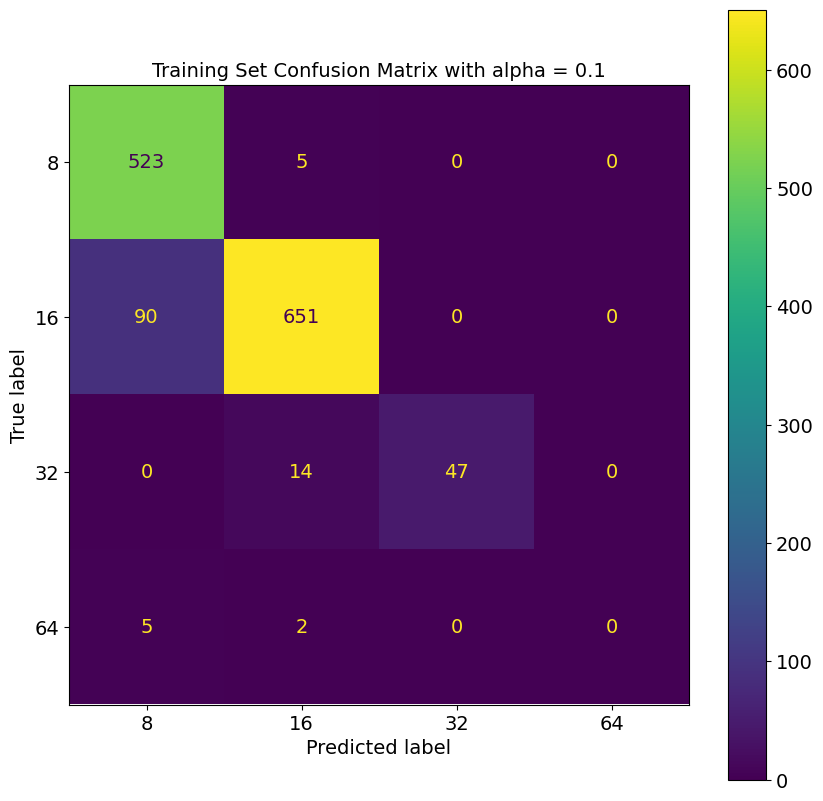

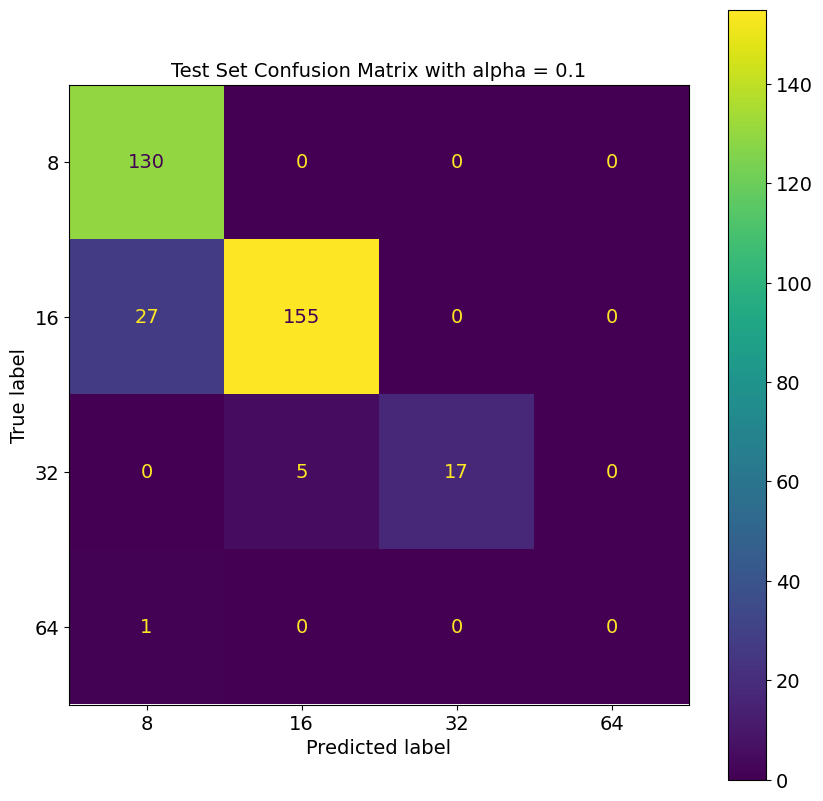

In [ ]:
# Display confusion matrix for training set
fig, ax = plt.subplots(figsize=(10, 10));
ConfusionMatrixDisplay.from_predictions(MF_train, MF_reg_predicted_train, ax = ax);
plt.title("Training Set Confusion Matrix with alpha = {}".format(alpha))
plt.show()

# Display confusion matrix for test set
fig, ax = plt.subplots(figsize=(10, 10));
ConfusionMatrixDisplay.from_predictions(MF_test, MF_reg_predicted_test, ax = ax);
plt.title("Test Set Confusion Matrix with alpha = {}".format(alpha))
plt.show()

## **5. PERFORMANCE EVALUATION**

### **5A. 'Test Percentile' Function Definition**

Up to this point, the results shown have tested just one percentile value, `α = 0.1`. The function **test_alpha()** takes in input the arrays of the training and test sets and a specific percentile α, and returns the number of incorrected MF assignments, number of MF overestimations, and number of MF underestimations for the test set. The tasks perform by this function are:
*   **Model Training:** Call the train_GBR() function from section 3C to perform the hyperparameters optimization for the specific alpha (which will vary), train the GBR model, and display the performance evaluation for the training set.
*   **Test Set Prediction:** Predict the SNR values for the test set.
*   **Incorrect Assignment Computation:** Compute the number of incorrect MF assignments, number of MF overestimations, and number of MF underestimations for the SNR values predicted for the test set.

In [ ]:
def test_alpha (X_train, y_train, X_test, y_test, alpha):

# Inputs:   - X_train: Array of features of the training dataset
#           - y_train: Array of labels of the training set
#           - X_test: Array of features of the test dataset
#           - y_test: Array of labels of the test set
#           - alpha: Alpha parameter
#
# Outputs:  - num_overrated_MF_train: Number of overestimated MF in the training set
#           - num_underrated_MF_train: Number of underestimated MF in the training set
#           - num_overrated_MF_test: Number of overestimated MF in the test set
#           - num_underrated_MF_test: Number of underestimated MF in the test set

    # Train a GBR model
    GBR, _ = train_GBR(X_train, y_train, alpha)

    # Predic the SNR values for the training and test sets
    yhat_GBR_train = GBR.predict(X_train)
    yhat_GBR_test = GBR.predict(X_test)

    # Compute the incorrect MF assignments for the training and test sets
    print('\n***** TRAINING MF OVER/UNDER-ESTIMATIONS *****')
    _ , _ , _, num_overrated_MF_train, num_underrated_MF_train = find_MF_errors(y_train, yhat_GBR_train)
    print('\n******* TEST MF OVER/UNDER-ESTIMATIONS *******')
    _ , _ , _, num_overrated_MF_test, num_underrated_MF_test = find_MF_errors(y_test, yhat_GBR_test)

    return num_overrated_MF_train, num_underrated_MF_train, num_overrated_MF_test, num_underrated_MF_test


### **5B. 'Test Percentile' Function Call**

Call the function **test_alpha()** using the training and test sets, and exploring different values of percentile α. Finally, store the number of overestimations and underestimations computed from the training and test sets for each of the alpha values explored.

In [ ]:
# INITIALIZATION

# Definition of number of overestimations and underestimations lists
num_overrated_MF_train_GBR_list = []
num_underrated_MF_train_GBR_list = []
num_overrated_MF_test_GBR_list = []
num_underrated_MF_test_GBR_list = []

# INCORRECT ASSINGMENTS COMPUTATION

# Define the values of alpha to explore
alpha_list = [0.01*i for i in range(5, 100, 5)]

# Compute the number of overestimations and underestimations for different alphas
for alpha in alpha_list:

    print('\n****************** TESTING ALPHA = {} ******************\n'.format(round(alpha, 2)))
    print('********* TRAINING TIME AND METRICS **********\n')
    num_overrated_MF_train, num_underrated_MF_train, num_overrated_MF_test, \
    num_underrated_MF_test = test_alpha(X_train, y_train, X_test, y_test, alpha)

    # Add the number of overestimations and underestimations lists to their lists
    num_overrated_MF_train_GBR_list.append(num_overrated_MF_train)
    num_underrated_MF_train_GBR_list.append(num_underrated_MF_train)
    num_overrated_MF_test_GBR_list.append(num_overrated_MF_test)
    num_underrated_MF_test_GBR_list.append(num_underrated_MF_test)


****************** TESTING ALPHA = 0.05 ******************

********* TRAINING TIME AND METRICS **********

Training time [s]: 0.721
Final training R2 score is: 0.911
Final training Mean Squared Error (MSE) is: 0.145
Final training Mean Pinball Loss (MPL) is: 0.018

***** TRAINING MF OVER/UNDER-ESTIMATIONS *****

Out of 1337 MF assignments: 
 - Number of incorrectly-assigned MFs: 193 (14.44 %)
 - Number of overrated MFs: 2
 - Number of underrated MFs: 191

******* TEST MF OVER/UNDER-ESTIMATIONS *******

Out of 335 MF assignments: 
 - Number of incorrectly-assigned MFs: 55 (16.42 %)
 - Number of overrated MFs: 0
 - Number of underrated MFs: 55

****************** TESTING ALPHA = 0.1 ******************

********* TRAINING TIME AND METRICS **********

Training time [s]: 0.542
Final training R2 score is: 0.943
Final training Mean Squared Error (MSE) is: 0.092
Final training Mean Pinball Loss (MPL) is: 0.028

***** TRAINING MF OVER/UNDER-ESTIMATIONS *****

Out of 1337 MF assignments: 
 - N

### **5C. MF Overestimations and Underestimations for Different Percentiles**

Display of the results of overestimations and underestimations for the training and test sets for different values of of percentile α. Moreover, also display the number of incorrect modulation format (MF) assignments, computed as the sum of overestimations and underestimations.

The number of overestimations in the training set for every value of alpha is : {0.05: 2, 0.1: 5, 0.15: 4, 0.2: 9, 0.25: 11, 0.3: 17, 0.35: 16, 0.4: 28, 0.45: 25, 0.5: 29, 0.55: 35, 0.6: 43, 0.65: 59, 0.7: 60, 0.75: 75, 0.8: 81, 0.85: 96, 0.9: 102, 0.95: 141}
The number of underestimations in the training set for every value of alpha is : {0.05: 191, 0.1: 115, 0.15: 84, 0.2: 75, 0.25: 65, 0.3: 60, 0.35: 56, 0.4: 46, 0.45: 48, 0.5: 38, 0.55: 37, 0.6: 26, 0.65: 19, 0.7: 17, 0.75: 15, 0.8: 13, 0.85: 10, 0.9: 10, 0.95: 8}



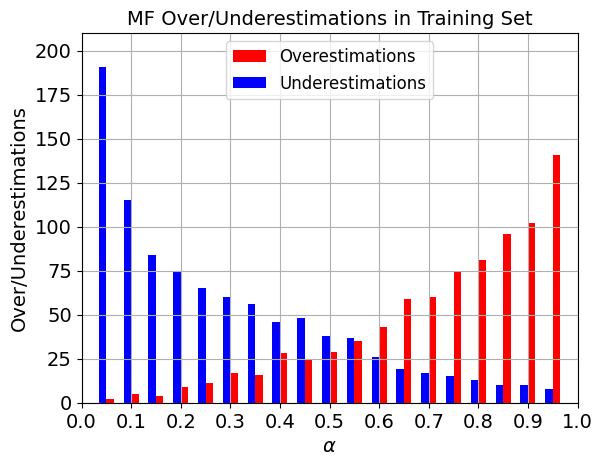

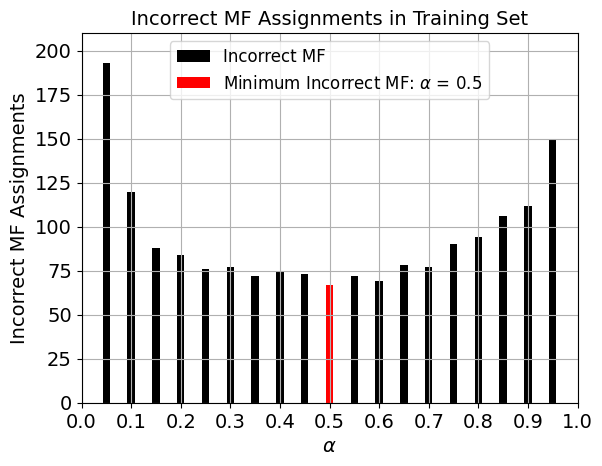

In [ ]:
# NUMBER OF OVERESTIMATIONS / UNDERESTIMATIONS TRAINING SET

# Build the dictionaries to store the number of over/underestimations for a given alpha
num_overrated_MF_train_GBR_dict = {}
num_underrated_MF_train_GBR_dict = {}
num_incorrect_MF_train_GBR_dict = {}
idx = 0
for alpha in alpha_list:
    alpha = round(alpha, 2)
    num_overrated_MF_train_GBR_dict[alpha] = num_overrated_MF_train_GBR_list[idx]
    num_underrated_MF_train_GBR_dict[alpha] = num_underrated_MF_train_GBR_list[idx]
    num_incorrect_MF_train_GBR_dict[alpha] = num_overrated_MF_train_GBR_list[idx] + \
                                             num_underrated_MF_train_GBR_list[idx]
    idx = idx + 1

print('The number of overestimations in the training set for every value of alpha is : {}'.format(num_overrated_MF_train_GBR_dict))
print('The number of underestimations in the training set for every value of alpha is : {}\n'.format(num_underrated_MF_train_GBR_dict))

# Define the bar width for the plot of bars
bar_width = 0.015

# Plot the number of incorrect assignments for different values of alpha
plt.figure()
plt.bar([alpha + bar_width/2 for alpha in alpha_list], num_overrated_MF_train_GBR_list, \
        label = 'Overestimations', width = bar_width, align = 'center', color = 'red')
plt.bar([alpha - bar_width/2 for alpha in alpha_list], num_underrated_MF_train_GBR_list, \
        label = 'Underestimations', width = bar_width, align = 'center', color = 'blue')

# Get the maximum value between over/underestimations to adjust Y axis automatically
if max(num_underrated_MF_train_GBR_list) > max(num_overrated_MF_train_GBR_list):
    lim_y_axis = max(num_underrated_MF_train_GBR_list)
else:
    lim_y_axis = max(num_overrated_MF_train_GBR_list)

# Set axis labels
plt.xlabel(r"$\alpha$")
plt.ylabel("Over/Underestimations")
plt.title("MF Over/Underestimations in Training Set")
plt.legend(loc = 'upper center')
plt.xticks(np.arange(0, 1.1, step = 0.1))
plt.xlim((0, 1))
plt.ylim((0, (lim_y_axis // 10 + 2) * 10))
plt.grid()

# Show the plot
plt.show()

# NUMBER OF INCORRECT MF ASSIGNMENTS TRAINING TRAINING

# Build the number of incorrect assignment list
num_incorrect_MF_train_list = [num_overrated + num_underrated for num_overrated, num_underrated in \
                         zip(num_overrated_MF_train_GBR_list, num_underrated_MF_train_GBR_list)]

# Find the minimum value in the number of incorrect MF list and its index
min_incorrect_MF_train = min(num_incorrect_MF_train_list)
min_index = [idx for idx, num_incorrect_MF in enumerate(num_incorrect_MF_train_list) if \
             num_incorrect_MF == min_incorrect_MF_train][0]

# Plot the number of incorrect assignments for different values of alpha
plt.figure()
plt.bar(alpha_list, num_incorrect_MF_train_list, label = 'Incorrect MF', width = bar_width, \
        align = 'center', color = 'black')
plt.bar(alpha_list[min_index], min_incorrect_MF_train, \
        label = r"Minimum Incorrect MF: $\alpha$ = " + str(round(alpha_list[min_index], 2)), \
        width = bar_width, align = 'center', color = 'red')

# Set axis labels
plt.xlabel(r"$\alpha$")
plt.ylabel("Incorrect MF Assignments")
plt.title("Incorrect MF Assignments in Training Set")
plt.legend( loc = 'upper center')
plt.xticks(np.arange(0, 1.1, step = 0.1))
plt.xlim((0, 1))
plt.ylim((0, (max(num_incorrect_MF_train_list) // 10 + 2) * 10))
plt.grid()

# Show the plot
plt.show()


The number of overestimations in the test set for every value of alpha is : {0.05: 0, 0.1: 0, 0.15: 2, 0.2: 2, 0.25: 5, 0.3: 6, 0.35: 7, 0.4: 7, 0.45: 8, 0.5: 8, 0.55: 10, 0.6: 12, 0.65: 16, 0.7: 17, 0.75: 21, 0.8: 21, 0.85: 21, 0.9: 23, 0.95: 34}
The number of underestimations in the test set for every value of alpha is : {0.05: 55, 0.1: 33, 0.15: 26, 0.2: 21, 0.25: 20, 0.3: 17, 0.35: 15, 0.4: 12, 0.45: 14, 0.5: 15, 0.55: 11, 0.6: 9, 0.65: 8, 0.7: 8, 0.75: 5, 0.8: 5, 0.85: 5, 0.9: 4, 0.95: 3}



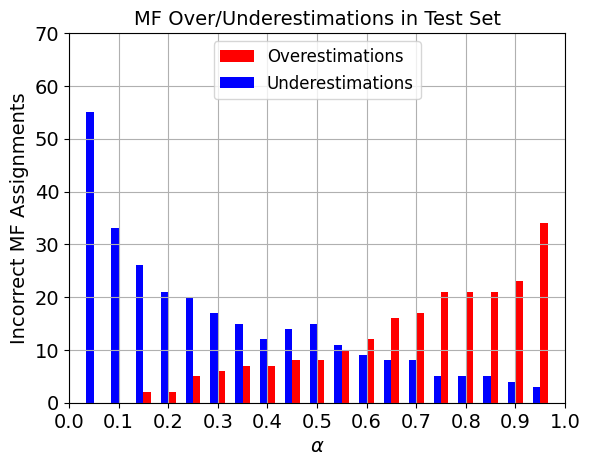

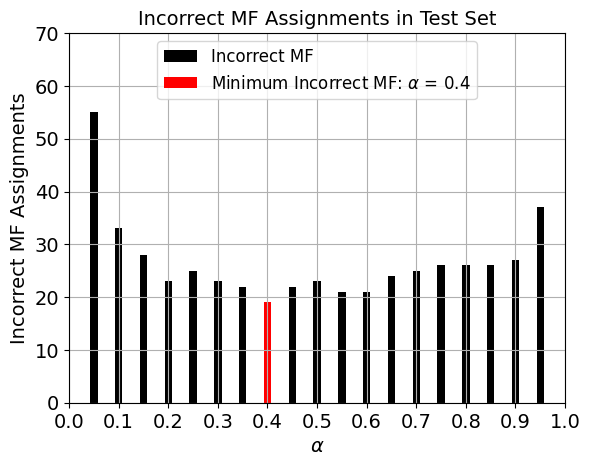

In [ ]:
# NUMBER OF OVERESTIMATIONS / UNDERESTIMATIONS TEST SET

# Build the dictionaries to store the number of over/underestimations for a given alpha
num_overrated_MF_test_GBR_dict = {}
num_underrated_MF_test_GBR_dict = {}
num_incorrect_MF_test_GBR_dict = {}
idx = 0
for alpha in alpha_list:
    alpha = round(alpha, 2)
    num_overrated_MF_test_GBR_dict[alpha] = num_overrated_MF_test_GBR_list[idx]
    num_underrated_MF_test_GBR_dict[alpha] = num_underrated_MF_test_GBR_list[idx]
    num_incorrect_MF_test_GBR_dict[alpha] = num_overrated_MF_test_GBR_list[idx] + \
                                             num_underrated_MF_test_GBR_list[idx]
    idx = idx + 1

print('The number of overestimations in the test set for every value of alpha is : {}'.format(num_overrated_MF_test_GBR_dict))
print('The number of underestimations in the test set for every value of alpha is : {}\n'.format(num_underrated_MF_test_GBR_dict))

# Plot the number of incorrect assignments for different values of alpha
plt.figure()
plt.bar([alpha + bar_width/2 for alpha in alpha_list], num_overrated_MF_test_GBR_list, \
        label = 'Overestimations', width = bar_width, align = 'center', color = 'red')
plt.bar([alpha - bar_width/2 for alpha in alpha_list], num_underrated_MF_test_GBR_list, \
        label = 'Underestimations', width = bar_width, align = 'center', color = 'blue')

# Get the maximum value between over/underestimations to adjust Y axis automatically
if max(num_underrated_MF_test_GBR_list) > max(num_overrated_MF_test_GBR_list):
    lim_y_axis = max(num_underrated_MF_test_GBR_list)
else:
    lim_y_axis = max(num_overrated_MF_test_GBR_list)

# Set axis labels
plt.xlabel(r"$\alpha$")
plt.ylabel("Incorrect MF Assignments")
plt.title("MF Over/Underestimations in Test Set")
plt.legend(loc = 'upper center')
plt.xticks(np.arange(0, 1.1, step = 0.1))
plt.xlim((0, 1))
plt.ylim((0, (lim_y_axis // 10 + 2) * 10))
plt.grid()

# Show the plot
plt.show()

# NUMBER OF INCORRECT MF ASSIGNMENTS TEST TRAINING

# Build the number of incorrect assignment list
num_incorrect_MF_test_list = [num_overrated + num_underrated for num_overrated, num_underrated in \
                              zip(num_overrated_MF_test_GBR_list, num_underrated_MF_test_GBR_list)]

# Find the minimum value in the number of incorrect MF list and its index
min_incorrect_MF_test = min(num_incorrect_MF_test_list)
min_index = [idx for idx, num_incorrect_MF in enumerate(num_incorrect_MF_test_list) if \
             num_incorrect_MF == min_incorrect_MF_test][0]

# Plot the number of incorrect assignments for different values of alpha
plt.figure()
plt.bar(alpha_list, num_incorrect_MF_test_list, label = 'Incorrect MF', width = bar_width, \
        align = 'center', color = 'black')
plt.bar(alpha_list[min_index], min_incorrect_MF_test, \
        label = r"Minimum Incorrect MF: $\alpha$ = " + str(round(alpha_list[min_index], 2)), \
        width = bar_width, align = 'center', color = 'red')

# Set axis labels
plt.xlabel(r"$\alpha$")
plt.ylabel("Incorrect MF Assignments")
plt.title("Incorrect MF Assignments in Test Set")
plt.legend( loc = 'upper center')
plt.xticks(np.arange(0, 1.1, step = 0.1))
plt.xlim((0, 1))
plt.ylim((0, (max(num_incorrect_MF_test_list) // 10 + 2) * 10))
plt.grid()

# Show the plot
plt.show()

### **5D. Cost Function: How to find the 'Best' α**?

In section 5C, the results indicate that the value of α that minimizes the total number of incorrect modulation format assignments for the training set and for the test set will be closer to `α = 0.5`.

However, as we saw in the lab session, it is preferred to have more underestimations than overestimations. Then, the concept of having a best α depends on the application and the relevance we give to overestimations and underestimations. How can we model this? Well, we can introduce weights to build a cost function and, recover from this, the value of α for which we get the best performance, the minimum cost.

The results of this section show us the value of α for which the cost function is minimized, being the cost function defined as:

`cost = 4*(number of overestimations) + (number of underestimations)`

In this way, we penalize more the overestimations over the underestimations.

The cost function for every value of alpha is : {0.05: 55, 0.1: 33, 0.15: 34, 0.2: 29, 0.25: 40, 0.3: 41, 0.35: 43, 0.4: 40, 0.45: 46, 0.5: 47, 0.55: 51, 0.6: 57, 0.65: 72, 0.7: 76, 0.75: 89, 0.8: 89, 0.85: 89, 0.9: 96, 0.95: 139}



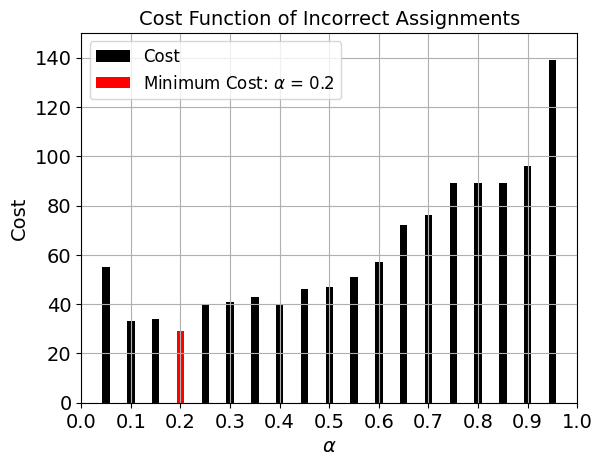

In [ ]:
# Define the weights of the number of overestimations and underestimations
coeff_over = 4
coeff_under = 1

# Build the cost function list
cost_function_list = [coeff_over*num_overrated + coeff_under*num_underrated for num_overrated, num_underrated in \
                         zip(num_overrated_MF_test_GBR_list, num_underrated_MF_test_GBR_list)]

cost_dict = {}
idx = 0
for alpha in alpha_list:
    alpha = round(alpha, 2)
    cost_dict[alpha] = cost_function_list[idx]
    idx = idx + 1

print('The cost function for every value of alpha is : {}\n'.format(cost_dict))

# Find the minimum cost and its index
min_cost = min(cost_function_list)
min_index = [idx for idx, cost in enumerate(cost_function_list) if \
             cost == min_cost][0]

# Plot the cost as function for different values of alpha
plt.figure()
plt.bar(alpha_list, cost_function_list, label = 'Cost', width = bar_width, \
        align = 'center', color = 'black')
plt.bar(alpha_list[min_index], min_cost, \
        label = r"Minimum Cost: $\alpha$ = " + str(round(alpha_list[min_index], 2)), \
        width = bar_width, align = 'center', color = 'red')

# Set axis labels
plt.xlabel(r"$\alpha$")
plt.ylabel("Cost")
plt.title("Cost Function of Incorrect Assignments")
plt.legend( loc = 'best')
plt.xticks(np.arange(0, 1.1, step = 0.1))
plt.xlim((0, 1))
plt.ylim((0, (max(cost_function_list) // 10 + 2) * 10))
plt.grid()

# Show the plot
plt.show()


# **II. CLASSIFICATION**

## **1. DATA PREPROCESSING**

### **1A. 'Ground Truth Conversion' Function Definition**

The **convert_ground_truth()** takes in input the arrays of ground truth SNR values of the training and test sets, and returns the corresponding ground truth modulation formats (MF) for the inputs.

In [ ]:
def convert_ground_truth(SNR_true_vect_train, SNR_true_vect_test):

# Inputs:   - SNR_true_vect_train: Array of ground truth SNR values of the training set
#           - SNR_true_vect_test: Array of ground truth SNR values of the test set
#
# Outputs:  - MF_true_vect_train: List of ground truth MF of the training set
#           - MF_true_vect_test: List of ground truth MF of the test set

    # INITIALIZATION

    MF_true_vect_train = []
    MF_true_vect_test = []

    # CONVERSION

    for SNR_train in SNR_true_vect_train:
        MF_train = SNR_to_MF(SNR_train)
        MF_true_vect_train.append(MF_train)

    for SNR_test in SNR_true_vect_test:
        MF_test = SNR_to_MF(SNR_test)
        MF_true_vect_test.append(MF_test)

    return MF_true_vect_train, MF_true_vect_test

### **1B. 'Ground Truth Conversion' Function Call**

Call the function **convert_ground_truth()** using the arrays of ground truth values obtained in section 3A. Then, the dimension of the returned array is checked.

In [ ]:
# Convert ground truth SNR values to MF
MF_train, MF_test = convert_ground_truth(y_train, y_test)

# Convert MF lists to arrays
y_train_new = np.array(MF_train)
y_test_new = np.array(MF_test)

# Check the dimension of the arrays
print('Dimension of the new training labels: ', str(len(y_train_new)))
print('Dimension of the new test labels: ', str(len(y_test_new)))

Dimension of the new training labels:  1337
Dimension of the new test labels:  335


## **2. TREE CLASSIFICATION MODEL**

### **2A. 'Train Gradient Boosting Classifier' Function Definition**

The function **train_GBC()** takes in input the training features array **X_train** and the new training labels **y_train_new**, and returns the best model that fits the inputs. This function performs three tasks:
*   **Hyperparameters Optimization:** Obtain the best combination of hyperparameters that fit inputs for the specific Gradient Boosting Classifier (GBC) model.
*   **Cross Validation:** Split in the training set into 5 folds (`cv = 5`) to average the performance across all the folds to get a more robust estimate of how well the model performs on unseen data.
*   **Model Training:** Train a Gradient Boosting Classifier (GBC) model. For the model, we use *GradientBoostingClassifier* from *sklearn.ensemble*.



Be aware that both tasks are performed using the *GridSearchCV* from *sklearn.model_selection*.

Reference:
*   https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
*   https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html

In [ ]:
def train_GBC(X_train, y_train):

# Inputs: - X_train: Array of features of the training dataset
#         - y_train: Array of MF labels of the training set
#
# Output: - model: Trained GBC model
#
# This function should:
#         * Perform RF hyperparameters optimization via crossvalidation
#         * Print best hyperparameters obtained with crossvalidation

    # Create a Gradient Boosting Classifier model
    gbc = GradientBoostingClassifier()

    # Define the initial grid of hyperparameters values to test
    initial_param_grid = {
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [1, 3, 5],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 3, 5]
    }

    # Define the reduced grid of hyperparameters values to test
    param_grid = {
        'learning_rate': [0.05],
        'max_depth': [3],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 5]
    }

    # Run the hyperparameter optimization and cross validation
    grid_search = GridSearchCV(estimator = gbc, param_grid = param_grid, cv = 5)

    # Fit the grid search to the training data
    grid_search.fit(X_train, y_train)

    # Get the best performing model
    model = grid_search.best_estimator_

    # Get the best set of hyperparameters
    best_params = grid_search.best_params_

    # Print the best parameters
    #print("Best hyperparameters:", best_params)

    return model


### **2B. 'Train Gradient Boosting Classifier' Function Call**

Call the function **train_GBC()** and print the training time and performance metrics of the training and test sets.


In [ ]:
# MODEL TRAINING

# Train the GBC model
t0 = time.time()
GBC = train_GBC(X_train, y_train_new)
t1 = time.time()

# Get the training time
training_time_GBC = round(t1-t0, 3)

print('Training time [s]: ' + str(training_time_GBC))

# Predict the output labels for the training and test sets
yhat_GBC_train = GBC.predict(X_train)
yhat_GBC_test = GBC.predict(X_test)

# PERFORMANCE METRICS EVALUATION

# Compute the performance metrics for the training set
accuracy_train = accuracy_score(y_train_new, yhat_GBC_train)
precision_train = precision_score(y_train_new, yhat_GBC_train, average = 'weighted')
recall_train = recall_score(y_train_new, yhat_GBC_train, average = 'weighted')
f1_train = f1_score(y_train_new, yhat_GBC_train, average = 'weighted')

# Print the performance metrics for the training set
print('\n********** TRAINING SCORES **********\n')
print('Gradient Boosting Classification')
print('Final training accuracy score is: ' + str(round(accuracy_train, 3)))
print('Final training precision score is: ' + str(round(precision_train, 3)))
print('Final training recall score is: ' + str(round(recall_train, 3)))
print('Final training F1 score is: ' + str(round(f1_train, 3)))

# Compute the performance metrics for the test set
accuracy_test = accuracy_score(y_test_new, yhat_GBC_test)
precision_test = precision_score(y_test_new, yhat_GBC_test, average = 'weighted')
recall_test = recall_score(y_test_new, yhat_GBC_test, average = 'weighted')
f1_test = f1_score(y_test_new, yhat_GBC_test, average = 'weighted')

# Print the performance metrics for the test set
print('\n********** TEST SCORES **************\n')
print('Gradient Boosting Classification')
print('Final test accuracy score is: ' + str(round(accuracy_test, 3)))
print('Final test precision score is: ' + str(round(precision_test, 3)))
print('Final test recall score is: ' + str(round(recall_test, 3)))
print('Final test F1 score is: ' + str(round(f1_test, 3)))

Training time [s]: 22.726

********** TRAINING SCORES **********

Gradient Boosting Classification
Final training accuracy score is: 0.97
Final training precision score is: 0.97
Final training recall score is: 0.97
Final training F1 score is: 0.97

********** TEST SCORES **************

Gradient Boosting Classification
Final test accuracy score is: 0.937
Final test precision score is: 0.938
Final test recall score is: 0.937
Final test F1 score is: 0.937


### **2C. Results Display**

Display the confusion matrices for the training and test sets using the corresponding arrays of ground truth and predicted modulation formats obtained in section 2B.

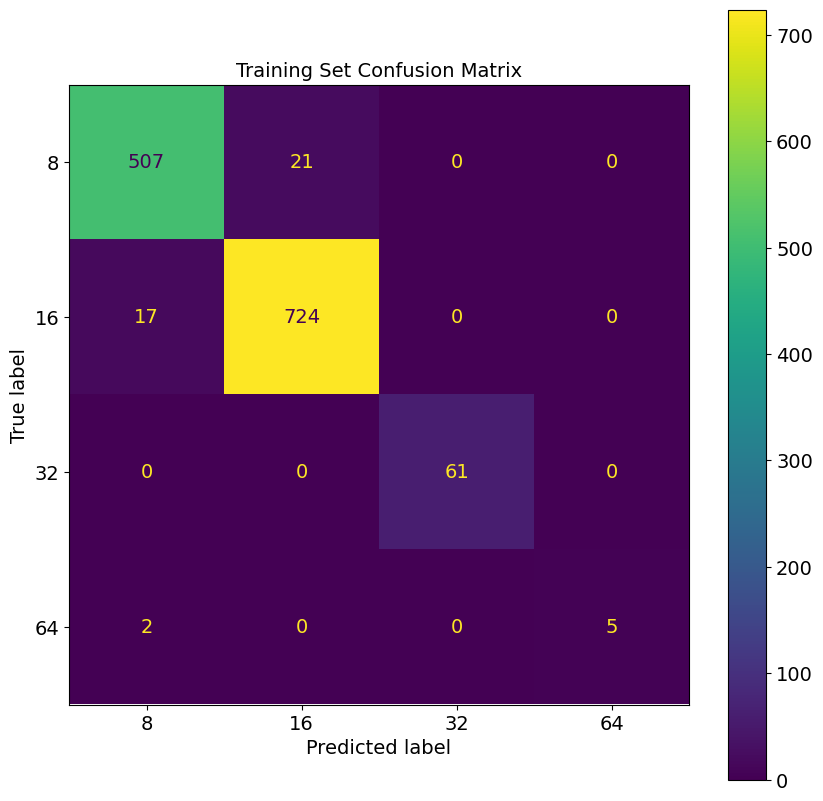

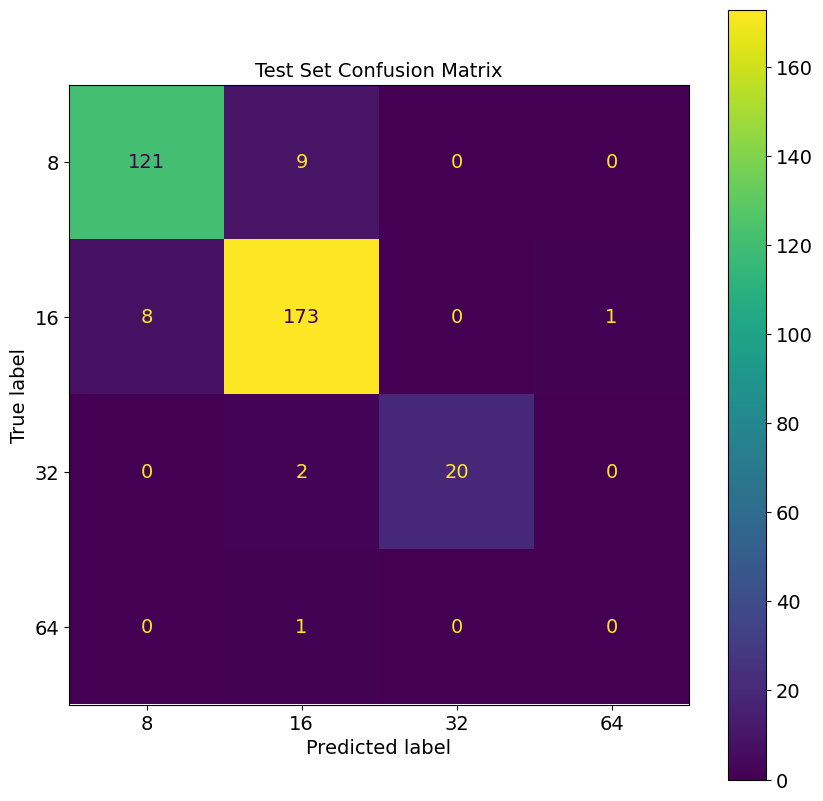

In [ ]:
# Display confusion matrix for training set
fig, ax = plt.subplots(figsize=(10, 10));
ConfusionMatrixDisplay.from_predictions(y_train_new, yhat_GBC_train, ax = ax);
plt.title("Training Set Confusion Matrix")
plt.show()

# Display confusion matrix for test set
fig, ax = plt.subplots(figsize=(10, 10));
ConfusionMatrixDisplay.from_predictions(y_test_new, yhat_GBC_test, ax = ax);
plt.title("Test Set Confusion Matrix")
plt.show()

## **3. CLASSIFICATION AND REGRESSION MODELS COMPARISON**

### **3A. Comparison of Number of Over/Underestimations**

Display a visual comparison of the number of overestimations, underestimations, and incorrect MF assignments for both, regressor and classifier. In this case, the number of overestimations, underestimations, and incorrect MF assignments vary according the value of α for the regressor, but for the classifier these are constant, then they are depicted as dotted lines.

Be aware that in the case the line of the overestimations or underestimations is not showed for the classifier, this is due to superposition (same number of overestimations and underestimations).

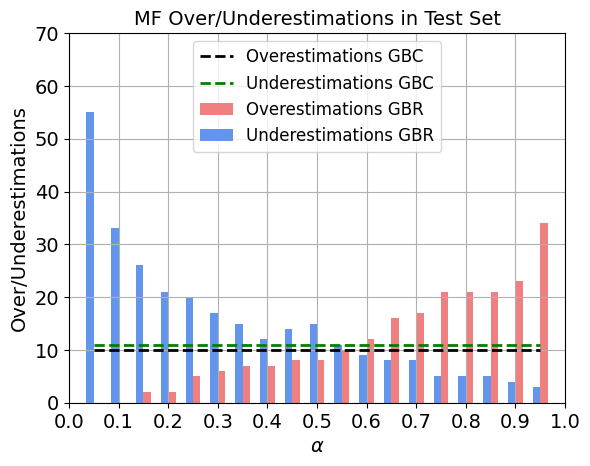

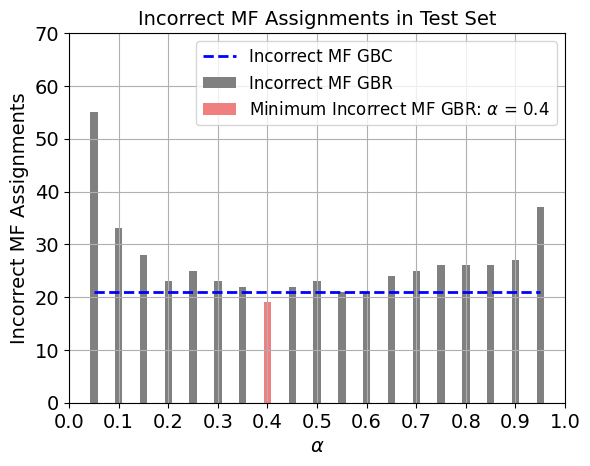

In [ ]:
# COMPARISON NUMBER OF OVERESTIMATIONS / UNDERESTIMATIONS

# Compute the number of overestimations and underestimations for the classifier
num_overrated_MF_GBC = np.count_nonzero(y_test_new < yhat_GBC_test)
num_underrated_MF_GBC = np.count_nonzero(y_test_new > yhat_GBC_test)

# Define the bar width for the plot of bars
bar_width = 0.015

# Plot the number of overestimations and underestimations for different values of alpha for the regressor
plt.figure()
plt.bar([alpha + bar_width/2 for alpha in alpha_list], num_overrated_MF_test_GBR_list, \
        label = 'Overestimations GBR', width = bar_width, align = 'center', color = 'lightcoral')
plt.bar([alpha - bar_width/2 for alpha in alpha_list], num_underrated_MF_test_GBR_list, \
        label = 'Underestimations GBR', width = bar_width, align = 'center', color = 'cornflowerblue')

# Define a reference of the number of overestimations and underestimations for the classifier
ref_overrated_MF_GBC = np.full(len(alpha_list), num_overrated_MF_GBC)
ref_underrated_MF_GBC = np.full(len(alpha_list), num_underrated_MF_GBC)

# Plot the number of overestimations and underestimations for the regressor
plt.plot(alpha_list, ref_overrated_MF_GBC, 'k--', label = 'Overestimations GBC', linewidth = 2)
plt.plot(alpha_list, ref_underrated_MF_GBC, 'g--', label = 'Underestimations GBC', linewidth = 2)

# Get the maximum value between over/underestimations to adjust Y axis automatically
if max(num_underrated_MF_test_GBR_list) > max(num_overrated_MF_test_GBR_list):
    lim_y_axis = max(num_underrated_MF_test_GBR_list)
else:
    lim_y_axis = max(num_overrated_MF_test_GBR_list)

# Set axis labels
plt.xlabel(r"$\alpha$")
plt.ylabel("Over/Underestimations")
plt.title("MF Over/Underestimations in Test Set")
plt.legend( loc = 'upper center')
plt.xticks(np.arange(0, 1.1, step = 0.1))
plt.xlim((0, 1))
plt.ylim((0, (lim_y_axis // 10 + 2) * 10))
plt.grid()

# Show the plot
plt.show()

# COMPARISON OF INCORRECT MF ASSIGNMENTS

# Compute the cost function for the classifier considering the weights
num_incorrect_MF_test_GBC = num_overrated_MF_GBC + num_underrated_MF_GBC

# Build the number of incorrect assignment list
num_incorrect_MF_test_list = [num_overrated + num_underrated for num_overrated, num_underrated in \
                              zip(num_overrated_MF_test_GBR_list, num_underrated_MF_test_GBR_list)]

# Find the minimum value in the number of incorrect MF list and its index
min_incorrect_MF_test = min(num_incorrect_MF_test_list)
min_index = [idx for idx, num_incorrect_MF in enumerate(num_incorrect_MF_test_list) if \
             num_incorrect_MF == min_incorrect_MF_test][0]

# Plot the cost function for the different values of alpha for the regressor
# Plot the cost function for classifier
plt.figure()
plt.bar(alpha_list, num_incorrect_MF_test_list, label = 'Incorrect MF GBR', width = bar_width, \
        align = 'center', color = 'gray')
plt.bar(alpha_list[min_index], min_incorrect_MF_test, \
        label = r"Minimum Incorrect MF GBR: $\alpha$ = " + str(round(alpha_list[min_index], 2)), \
        width = bar_width, align = 'center', color = 'lightcoral')
plt.plot(alpha_list, np.full(len(alpha_list), num_incorrect_MF_test_GBC), 'b--', \
         label = 'Incorrect MF GBC', linewidth = 2)

# Set axis labels
plt.xlabel(r"$\alpha$")
plt.ylabel("Incorrect MF Assignments")
plt.title("Incorrect MF Assignments in Test Set")
plt.legend(loc = 'best')
plt.xticks(np.arange(0, 1.1, step = 0.1))
plt.xlim((0, 1))
plt.ylim((0, (max(num_incorrect_MF_test_list) // 10 + 2) * 10))
plt.grid()

# Show the plot
plt.show()

### **3B. Comparison considering a Cost Function**

Display a visual comparison of the number of overestimations and underestimations considering a cost function. In this case, we consider the same weights of section 5D, to have a fair comparison of the regressor and classifier.

The conclusion from the results showed in this part (cost of the regressor greater than the cost of the classifier when we consider a cost function that prioritizes one over the other) is that if underestimations or overestimations are more relevant than their counterpart, then it will be more appropriate to use the regressor with quantile loss than a classifier since this model gives us the flexibility to predict values giving preference to overestimations or underestimations according to the value of α.

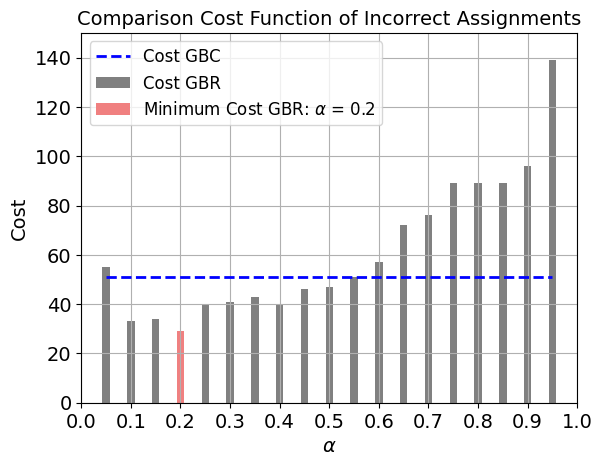

In [ ]:
# Define the weights of the number of overestimations and underestimations
coeff_over = 4
coeff_under = 1

# Compute the cost function for the classifier considering the weights
cost_function_GBC = coeff_over*num_overrated_MF_GBC + coeff_under*num_underrated_MF_GBC

# Find the minimum cost and its index
min_cost = min(cost_function_list)
min_index = [idx for idx, cost in enumerate(cost_function_list) if \
             cost == min_cost][0]

# Plot the cost function for the different values of alpha for the regressor
# Plot the cost function for classifier
plt.figure()
plt.bar(alpha_list, cost_function_list, label = 'Cost GBR', width = bar_width, \
        align = 'center', color = 'gray')
plt.bar(alpha_list[min_index], min_cost, width = bar_width, align = 'center', color = 'lightcoral', \
        label = r"Minimum Cost GBR: $\alpha$ = " + str(round(alpha_list[min_index], 2)))
plt.plot(alpha_list, np.full(len(alpha_list), cost_function_GBC), 'b--', \
         label = 'Cost GBC', linewidth = 2)

# Set axis labels
plt.xlabel(r"$\alpha$")
plt.ylabel("Cost")
plt.title("Comparison Cost Function of Incorrect Assignments")
plt.legend(loc = 'best')
plt.xticks(np.arange(0, 1.1, step = 0.1))
plt.xlim((0, 1))
plt.ylim((0, (max(cost_function_list) // 10 + 2) * 10))
plt.grid()

# Show the plot
plt.show()

# **III. TRANSFER LEARNING**

## **1. REGRESSION WITHOUT DOMAIN ADAPTATION**

Train a Gradient Boosting Regressor (GBR) model using Transfer Learning. In this case, the German dataset is used as training set (source domain) and the European dataset is used as test set (target domain).

### **1A. Read Datafiles**

Call the function **read_dataset()** using the corresponding input files. In this case, there is a implicit declaration of the data for the training set (German dataset) and the data for the test set (European dataset).

Then, the dimensions of the returned values are checked, and the statistics (mean, variance, and standard deviation) are computed and printed for all paths for the number of spans along the path, total lightpath (total span) length, maximum number of channels per link, and SNR values.

In [ ]:
# READ DATAFILE AND LENGTH CHECK

# Path of the datafiles
datafile_german = "/content/drive/MyDrive/NDA/Final_project/Dataset_german_17_node.dat"
datafile_european = "/content/drive/MyDrive/NDA/Final_project/Dataset_european_19_node.dat"

# Read datafile to get the information
spans_german, channels_link_german, snr_values_german = read_dataset(datafile_german);
spans_european, channels_link_european, snr_values_european = read_dataset(datafile_european);

### **1B. Features Extraction**

Call the function **extract_features()** using the lists of spans and channels per link obtained in the previous section. Then, the dimension of the returned array is checked, and the list of SNR values is converted into a numpy array.

In [ ]:
# FEATURES EXTRACTION

# Extract features of the new training set
X_train_TL = extract_features(spans_german, channels_link_german)
print('Shape of features array of the training set: ', str(X_train.shape))

# Extract features of the new test set
X_test_TL = extract_features(spans_european, channels_link_european)
print('\n****************************************************\n')
print('Shape of features array of the test set: ', str(X_test.shape))

# Convert the SNR list to an array
y_train_TL = np.array(snr_values_german)
y_test_TL = np.array(snr_values_european)

Shape of features array of the training set:  (1337, 8)

****************************************************

Shape of features array of the test set:  (335, 8)


### **1C. Features Distribution Plot Target Domain**

Scatterplots with distribution of SNR values against each of the features of the target domain are drawn. Why only the target domain and not the source domain? The features distribution of the source domain can already be found in **section 2C** of the **I. Regression** part.

Saved combined plot to /content/drive/MyDrive/NDA/Final_project/Images/European_dataset/Europear_dataset_combined_plot.png


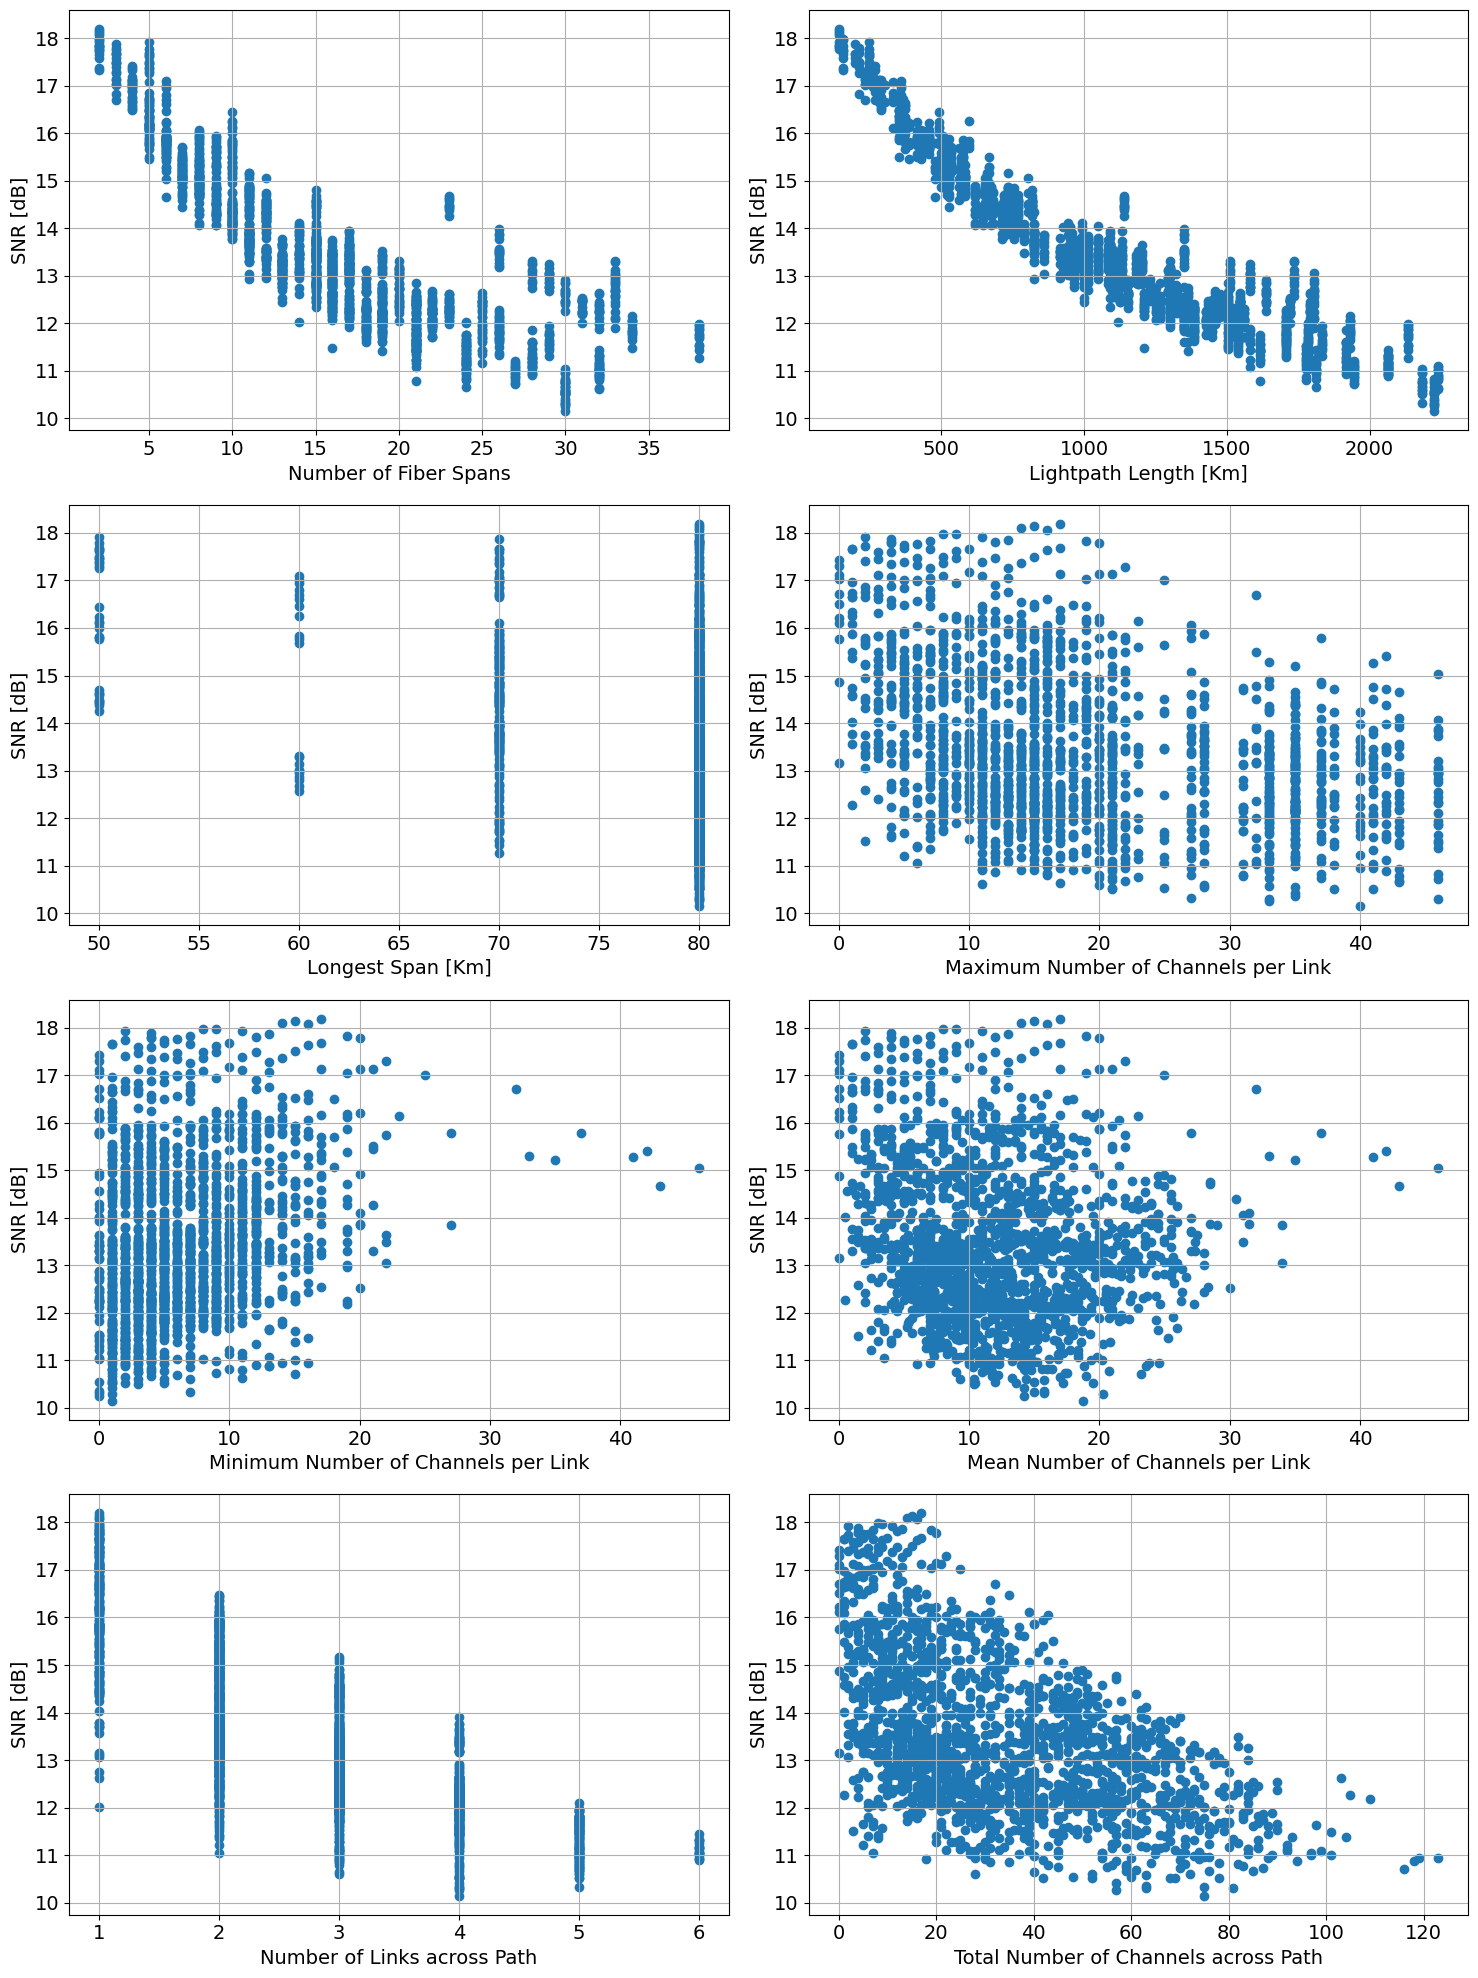

In [ ]:
# Specify the folder in Google Drive where to save the plots
drive_folder = '/content/drive/MyDrive/NDA/Final_project/Images/European_dataset'

# Create the folder if it does not exist
os.makedirs(drive_folder, exist_ok = True)

# Figure settings to improve readability
FONT_SIZE = 14
plt.rc('font', size = FONT_SIZE)         # Control default text sizes
plt.rc('axes', titlesize = FONT_SIZE)    # Fontsize of the axes title
plt.rc('axes', labelsize = FONT_SIZE)    # Fontsize of the x and y labels
plt.rc('xtick', labelsize = FONT_SIZE)   # Fontsize of the tick labels
plt.rc('ytick', labelsize = FONT_SIZE)   # Fontsize of the tick labels
plt.rc('legend', fontsize = 12)          # Legend fontsize
plt.rc('figure', titlesize = FONT_SIZE)  # Fontsize of the figure title

# List of feature names for labeling
feature_names = [ 'Number of Fiber Spans',
                  'Lightpath Length [Km]',
                  'Longest Span [Km]',
                  'Maximum Number of Channels per Link',
                  'Minimum Number of Channels per Link',
                  'Mean Number of Channels per Link',
                  'Number of Links across Path',
                  'Total Number of Channels across Path' ]

# Create a figure with subplots with 4 rows and 2 columns
fig, axs = plt.subplots(4, 2, figsize=(15, 20))

# Generate and save plots in subplots
for i, ax in enumerate(axs.flatten()):
    ax.scatter(X_test_TL[:, i], snr_values_european)
    ax.set_xlabel(feature_names[i])
    ax.set_ylabel('SNR [dB]')
    ax.grid()

plt.tight_layout()

# Save the combined image
file_name = 'Europear_dataset_combined_plot.png'
file_path = os.path.join(drive_folder, file_name)
plt.savefig(file_path)
print(f"Saved combined plot to {file_path}")

plt.show()

### **1D. Features Normalization**

The training set is normalized, and according to the training set statistics, the corresponding transformation is applied to the test set. An important remark to be made so far is:
*   **Normal Approach:** One dataset is split on training and test sets, and then the normalization is performed on both sets. Probabilisticly, it is expected that the features' distribution of the training set will not differ much from the distribution of the test set. This is good for the model training since it means that the model can perform well on the test set.
*   **Transfer Learning Approach:** Normalization is applied on one dataset and the same transformation is applied to a different dataset, which potentially may have a different distribution. If this is the case, it is expected to have a poor performance on the test set since it comes from a different dataset that the one of the training set.

In [ ]:
# Normalize the training and test datasets according to the training set statistics
scaler = StandardScaler()
X_train_TL = scaler.fit_transform(X_train_TL)
X_test_TL = scaler.transform(X_test_TL)

### **1E. Tree Regression Model Training**

Call the function **train_GBR()** using as inputs the training features array **X_train_TL**, the training labels array **y_train_TL**, and the percentile **α**. After the function call, the performance metrics of the model (R2 score, MSE, and MPL) are displayed in the cell output.

In [ ]:
# Define a value of alpha
alpha = 0.10

# Call the function to train the model
GBR_TL, train_duration_TL = train_GBR(X_train_TL, y_train_TL, alpha)

Training time [s]: 1.492
Final training R2 score is: 0.951
Final training Mean Squared Error (MSE) is: 0.08
Final training Mean Pinball Loss (MPL) is: 0.027


### **1F. Performance Metrics Evaluation**

Display the performance metrics (R2 score, MSE, and MPL) for training and test sets.

In [ ]:
# Performance metrics evaluation for training set
r2_GBR_train_TL = GBR_TL.score(X_train_TL, y_train_TL)
yhat_GBR_train_TL = GBR_TL.predict(X_train_TL)
mse_GBR_train_TL = mean_squared_error(y_train_TL, yhat_GBR_train_TL)
mpl_GBR_train_TL = mean_pinball_loss(y_train_TL, yhat_GBR_train_TL, alpha = alpha)

print('\n******** TRAINING SCORES ************\n')
print('Gradient Boosting Regression - Transfer Learning')
print('Final training R2 score is: ' + str(round(r2_GBR_train_TL, 3)))
print('Final training MSE is: ' + str(round(mse_GBR_train_TL, 3)))
print('Final training MPL is: ' + str(round(mpl_GBR_train_TL, 3)))

# Performance metrics evaluation for test set
r2_GBR_test_TL = GBR.score(X_test_TL, y_test_TL)
yhat_GBR_test_TL = GBR.predict(X_test_TL)
mse_GBR_test_TL = mean_squared_error(y_test_TL, yhat_GBR_test_TL)
mpl_GBR_test_TL = mean_pinball_loss(y_test_TL, yhat_GBR_test_TL, alpha = alpha)

print('\n********** TEST SCORES **************\n')
print('Gradient Boosting Regression - Transfer Learning')
print('Final test R2 score is: ' + str(round(r2_GBR_test_TL, 3)))
print('Final test MSE is: ' + str(round(mse_GBR_test_TL, 3)))
print('Final test MPL is: ' + str(round(mpl_GBR_test_TL, 3)))


******** TRAINING SCORES ************

Gradient Boosting Regression - Transfer Learning
Final training R2 score is: 0.951
Final training MSE is: 0.08
Final training MPL is: 0.027

********** TEST SCORES **************

Gradient Boosting Regression - Transfer Learning
Final test R2 score is: 0.491
Final test MSE is: 1.316
Final test MPL is: 0.718


### **1G. Overestimations and Underestimations for Training and Test Sets**

Compute the Modulation Format (MF) overestimations and underestimations to evaluate the overall performance of the approach.

From the results below, it can be seen that the performance over the test set is not good and this indicates that training the model with one dataset and apply it to the other dataset is not a good approach, probably because the statistics of the features array are not similar.

In [ ]:
# Predict the values for the training set
yhat_GBR_train_TL = GBR_TL.predict(X_train_TL)

# Compute the incorrect MF assignments for the training set
print('******* TRAINING MF OVER/UNDER-ESTIMATIONS *******')
MF_train_TL, MF_reg_predicted_train_TL, _ , _ , _ = find_MF_errors(y_train_TL, yhat_GBR_train_TL)

# Predict the values for the test set
yhat_GBR_test_TL = GBR_TL.predict(X_test_TL)

# Compute the incorrect MF assignments for the test set
print('\n********* TEST MF OVER/UNDER-ESTIMATIONS *********')
MF_test_TL, MF_reg_predicted_test_TL, _ , _ , _ = find_MF_errors(y_test_TL, yhat_GBR_test_TL)

******* TRAINING MF OVER/UNDER-ESTIMATIONS *******

Out of 1672 MF assignments: 
 - Number of incorrectly-assigned MFs: 140 (8.37 %)
 - Number of overrated MFs: 3
 - Number of underrated MFs: 137

********* TEST MF OVER/UNDER-ESTIMATIONS *********

Out of 1833 MF assignments: 
 - Number of incorrectly-assigned MFs: 806 (43.97 %)
 - Number of overrated MFs: 733
 - Number of underrated MFs: 73


### **1H. Display of Results**

Display the confusion matrices for the training and test sets using the corresponding arrays of ground truth and predicted modulation formats.

One important thing to note from the confusion matrix of the test set drawn below is that: **the data points with ground truth MF equal to 4-QAM are all mislabeled with a predicted MF equal to 8-QAM**. Why? The answer comes from the confusion matrix of the training set.

It can be seen in the confusion matrix of the training set that the set of real and predicted MF do not include the 4-QAM. This means that the test set (European dataset) contains ground truth SNR labels outside the range of the ground truth SNR values of the training set (German dataset). **Therefore, the regressor does not perform very well in cases when it has to extrapolate values and this does actually makes sense since a tree model is being used.**

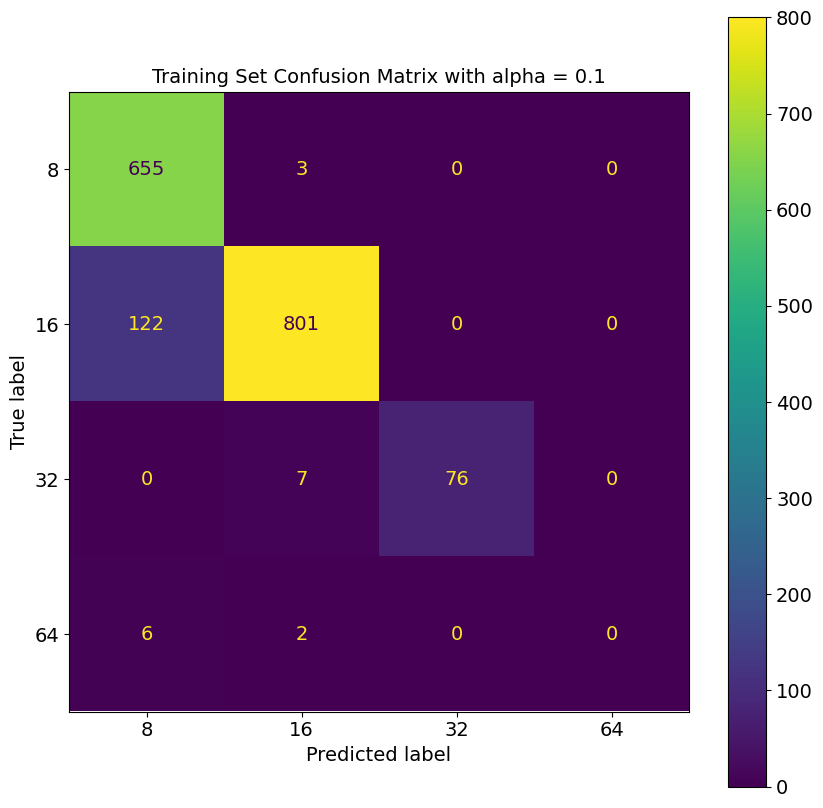

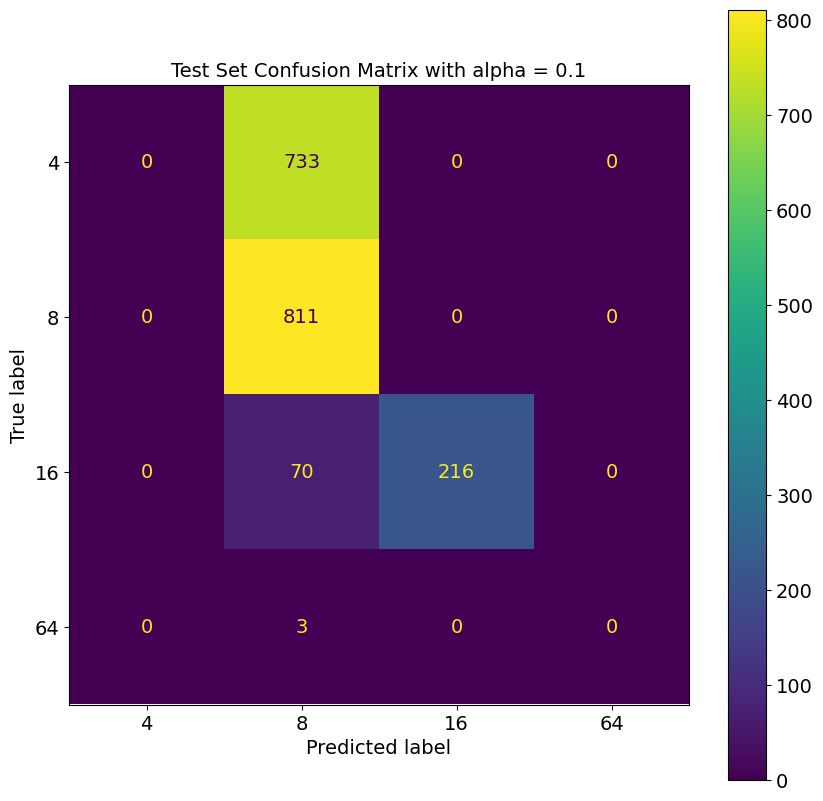

In [ ]:
# Display confusion matrix for test set
fig, ax = plt.subplots(figsize=(10, 10));
ConfusionMatrixDisplay.from_predictions(MF_train_TL, MF_reg_predicted_train_TL, ax = ax);
plt.title("Training Set Confusion Matrix with alpha = {}".format(alpha))
plt.show()

# Display confusion matrix for test set
fig, ax = plt.subplots(figsize=(10, 10));
ConfusionMatrixDisplay.from_predictions(MF_test_TL, MF_reg_predicted_test_TL, ax = ax);
plt.title("Test Set Confusion Matrix with alpha = {}".format(alpha))
plt.show()

## **2. CLASSIFICATION WITHOUT DOMAIN ADAPTATION**

Train a Gradient Boosting Classifier (GBC) model using Transfer Learning. In this case, the German dataset is used as training set (source domain) and the European dataset is used as test set (target domain).

### **2A. Tree Classification Model Training**

Convert the ground truth SNR values to ground truth modulation formats (MF), and call the function **train_GBC()** to train the model using as inputs the training features array and the new training labels (modulation formats) of the source domain.

In [ ]:
# MODEL TRAINING

# Convert ground truth SNR values to MF
MF_train_TL, MF_test_TL = convert_ground_truth(y_train_TL, y_test_TL)

# Convert the SNR list to an array
y_train_TL_new = np.array(MF_train_TL)
y_test_TL_new = np.array(MF_test_TL)

# Train the GBC model
t0 = time.time()
GBC_TL = train_GBC(X_train_TL, y_train_TL_new)
t1 = time.time()

# Get the training time
training_time_GBC_TL = round(t1-t0, 3)

print('Training time [s]: ' + str(training_time_GBC_TL))


Training time [s]: 39.849


### **2B. Performance Metrics Evaluation**

Display the performance metrics for training and test sets.

In [ ]:
# PERFORMANCE METRICS EVALUATION

# Predict the output labels for the training and test sets
yhat_GBC_train_TL = GBC_TL.predict(X_train_TL)
yhat_GBC_test_TL = GBC_TL.predict(X_test_TL)

# Compute the performance metrics for the training set
accuracy_train_TL = accuracy_score(y_train_TL_new, yhat_GBC_train_TL)
precision_train_TL = precision_score(y_train_TL_new, yhat_GBC_train_TL, average = 'weighted')
recall_train_TL = recall_score(y_train_TL_new, yhat_GBC_train_TL, average = 'weighted')
f1_train_TL = f1_score(y_train_TL_new, yhat_GBC_train_TL, average = 'weighted')

# Print the performance metrics for the training set
print('\n********** TRAINING SCORES **********\n')
print('Gradient Boosting Classification - Transfer Learning')
print('Final training accuracy score is: ' + str(round(accuracy_train_TL, 3)))
print('Final training precision score is: ' + str(round(precision_train_TL, 3)))
print('Final training recall score is: ' + str(round(recall_train_TL, 3)))
print('Final training F1 score is: ' + str(round(f1_train_TL, 3)))

# Compute the performance metrics for the test set
accuracy_test_TL = accuracy_score(y_test_TL_new, yhat_GBC_test_TL)
precision_test_TL = precision_score(y_test_TL_new, yhat_GBC_test_TL, average = 'weighted')
recall_test_TL = recall_score(y_test_TL_new, yhat_GBC_test_TL, average = 'weighted')
f1_test_TL = f1_score(y_test_TL_new, yhat_GBC_test_TL, average = 'weighted')

# Print the performance metrics for the test set
print('\n********** TEST SCORES **************\n')
print('Gradient Boosting Classification - Transfer Learning')
print('Final test accuracy score is: ' + str(round(accuracy_test_TL, 3)))
print('Final test precision score is: ' + str(round(precision_test_TL, 3)))
print('Final test recall score is: ' + str(round(recall_test_TL, 3)))
print('Final test F1 score is: ' + str(round(f1_test_TL, 3)))



********** TRAINING SCORES **********

Gradient Boosting Classification - Transfer Learning
Final training accuracy score is: 0.967
Final training precision score is: 0.967
Final training recall score is: 0.967
Final training F1 score is: 0.966

********** TEST SCORES **************

Gradient Boosting Classification - Transfer Learning
Final test accuracy score is: 0.565
Final test precision score is: 0.364
Final test recall score is: 0.565
Final test F1 score is: 0.433


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **2C. Overestimations and Underestimations for Training and Test Sets**

Compute the Modulation Format (MF) overestimations and underestimations to evaluate the overall performance of the Transfer Learning without Domain Adaptation approach.

In [ ]:
# Compute the number of over/under-estimations for the training set
num_overrated_MF_train_GBC_TL = np.count_nonzero(y_train_TL_new < yhat_GBC_train_TL)
num_underrated_MF_train_GBC_TL = np.count_nonzero(y_train_TL_new > yhat_GBC_train_TL)
num_incorrect_MF_train_GBC_TL = num_overrated_MF_train_GBC_TL + num_underrated_MF_train_GBC_TL
num_total_MF_train_TL = len(y_train_TL_new)
percentage_incorrect_MF_train_GBC_TL = round(100*(num_incorrect_MF_train_GBC_TL/num_total_MF_train_TL), 3)

# Compute the number of over/under-estimations for the test set
num_overrated_MF_test_GBC_TL = np.count_nonzero(y_test_TL_new < yhat_GBC_test_TL)
num_underrated_MF_test_GBC_TL = np.count_nonzero(y_test_TL_new > yhat_GBC_test_TL)
num_incorrect_MF_test_GBC_TL = num_overrated_MF_test_GBC_TL + num_underrated_MF_test_GBC_TL
num_total_MF_test_TL = len(y_test_TL_new)
percentage_incorrect_MF_test_GBC_TL = round(100*(num_incorrect_MF_test_GBC_TL/num_total_MF_test_TL), 3)

# Display the incorrect MF assignments for the training set
print('******* TRAINING MF OVER/UNDER-ESTIMATIONS *******')
print('\nOut of {} MF assignments: '.format(num_total_MF_train_TL))
print(' - Number of incorrectly-assigned MFs: {} ({} %)'.format(num_incorrect_MF_train_GBC_TL, percentage_incorrect_MF_train_GBC_TL))
print(' - Number of overrated MFs: {}'.format(num_overrated_MF_train_GBC_TL))
print(' - Number of underrated MFs: {}'.format(num_underrated_MF_train_GBC_TL))

# Display the incorrect MF assignments for the test set
print('\n********* TEST MF OVER/UNDER-ESTIMATIONS *********')
print('\nOut of {} MF assignments: '.format(num_total_MF_test_TL))
print(' - Number of incorrectly-assigned MFs: {} ({} %)'.format(num_incorrect_MF_test_GBC_TL, percentage_incorrect_MF_test_GBC_TL))
print(' - Number of overrated MFs: {}'.format(num_overrated_MF_test_GBC_TL))
print(' - Number of underrated MFs: {}'.format(num_underrated_MF_test_GBC_TL))


******* TRAINING MF OVER/UNDER-ESTIMATIONS *******

Out of 1672 MF assignments: 
 - Number of incorrectly-assigned MFs: 56 (3.349 %)
 - Number of overrated MFs: 26
 - Number of underrated MFs: 30

********* TEST MF OVER/UNDER-ESTIMATIONS *********

Out of 1833 MF assignments: 
 - Number of incorrectly-assigned MFs: 797 (43.481 %)
 - Number of overrated MFs: 763
 - Number of underrated MFs: 34


### **2D. Display of Results**

Display the confusion matrices for the training and test sets using the corresponding arrays of ground truth and predicted modulation formats.

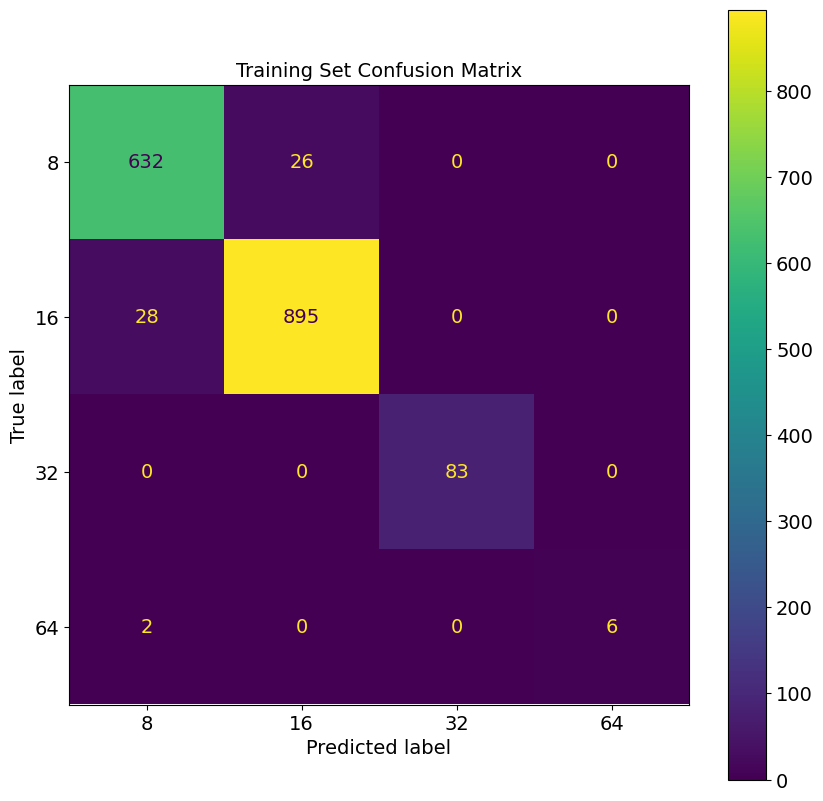

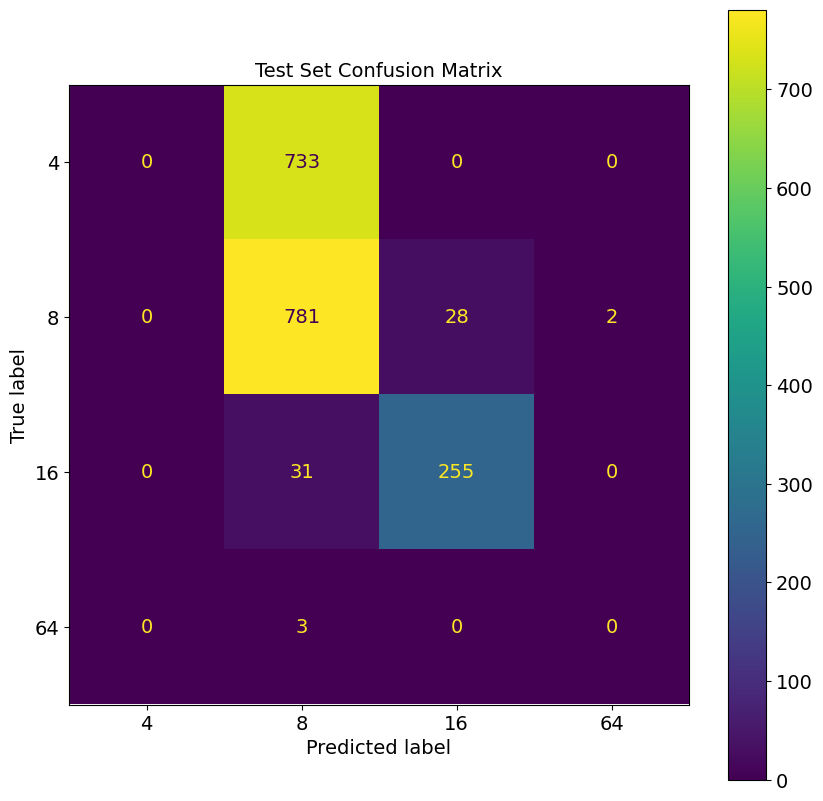

In [ ]:
# Predict the output labels for the training set
yhat_GBC_train_TL = GBC_TL.predict(X_train_TL)

# Display confusion matrix for training set
fig, ax = plt.subplots(figsize=(10, 10));
ConfusionMatrixDisplay.from_predictions(y_train_TL_new, yhat_GBC_train_TL, ax = ax);
plt.title("Training Set Confusion Matrix")
plt.show()

# Predict the output labels for the test set
yhat_GBC_test_TL = GBC_TL.predict(X_test_TL)

# Display confusion matrix for test set
fig, ax = plt.subplots(figsize=(10, 10));
ConfusionMatrixDisplay.from_predictions(y_test_TL_new, yhat_GBC_test_TL, ax = ax);
plt.title("Test Set Confusion Matrix")
plt.show()

## **3. REGRESSION WITH DOMAIN ADAPTATION**

Train a Gradient Boosting Regressor (GBR) model using Transfer Learning with Domain Adaptation. In this case, the German dataset is used as training set (source domain) along with some points of the European dataset. The remaining points of the European dataset is used as test set (target domain).

### **3A. Train and Test Sets Formation**

Since in this part Transfer Learning with Domain Adaptation is applied, the training set must be build from the original training set (German dataset) plus some additional points from the original test set (European dataset) from the case without domain adaptation. In this case, 200 data points are taken from the European dataset to build the new training set.

In [ ]:
# Define number of points from the European dataset that will be part of the traning set
number_points = 200

# Initialize the matrices and vector for the training data
spans_train_TL_DA = []
channels_link_train_TL_DA = []
snr_values_train_TL_DA = []

# Gather the training data from the German dataset
for span in spans_german:
    spans_train_TL_DA.append(span)
for channels in channels_link_german:
    channels_link_train_TL_DA.append(span)
for snr in snr_values_german:
    snr_values_train_TL_DA.append(snr)

# Gather the training data from the European dataset
for span in spans_european[0:number_points]:
    spans_train_TL_DA.append(span)
for channels in channels_link_european[0:number_points]:
    channels_link_train_TL_DA.append(span)
for snr in snr_values_european[0:number_points]:
    snr_values_train_TL_DA.append(snr)

# Initialize the matrices and vector for the test data
spans_test_TL_DA = []
channels_link_test_TL_DA = []
snr_values_test_TL_DA = []

# Gather the test data
for span in spans_european[number_points:]:
    spans_test_TL_DA.append(span)
for channels in channels_link_european[number_points:]:
    channels_link_test_TL_DA.append(span)
for snr in snr_values_european[number_points:]:
    snr_values_test_TL_DA.append(snr)

# Check the length of the training set matrices and vector
print('Length of Training Set Spans list: {}'.format(str(len(spans_train_TL_DA))))
print('Length of Training Set Channels per link list: {}'.format(str(len(channels_link_train_TL_DA))))
print('Length of Training Set SNR list: {}'.format(str(len(snr_values_train_TL_DA))))

# Check the length of the test set matrices and vector
print('\n**************************\n')
print('Length of Test Set Spans list: {}'.format(str(len(spans_test_TL_DA))))
print('Length of Test Set Channels per link list: {}'.format(str(len(channels_link_test_TL_DA))))
print('Length of Test Set SNR list: {}'.format(str(len(snr_values_test_TL_DA))))


Length of Training Set Spans list: 1872
Length of Training Set Channels per link list: 1872
Length of Training Set SNR list: 1872

**************************

Length of Test Set Spans list: 1633
Length of Test Set Channels per link list: 1633
Length of Test Set SNR list: 1633


### **3B. Features Extraction**

Call the function **extract_features()** using the lists of spans and channels per link obtained in the previous section for the new training and test sets. Moreover, also convert the list of SNR values to a numpy array and check its length.


In [ ]:
# FEATURES EXTRACTION

# Extract features of the new training set
X_train_TL_DA = extract_features(spans_train_TL_DA, channels_link_train_TL_DA)
print('Shape of features matrix of the tranining set: ', str(X_train_TL_DA.shape))
print('\n**************************\n')

# Extract features of the new test set
X_test_TL_DA = extract_features(spans_test_TL_DA, channels_link_test_TL_DA)
print('Shape of features matrix of the test set: ', str(X_test_TL_DA.shape))
print('\n**************************\n')

# Convert the SNR list of the training set to an array
y_train_TL_DA = np.array(snr_values_train_TL_DA)
print('Shape of SNR array of the tranining set: ', str(y_train_TL_DA.shape))
print('\n**************************\n')

# Convert the SNR list of the test set to an array
y_test_TL_DA = np.array(snr_values_test_TL_DA)
print('Shape of SNR array of the test set: ', str(y_test_TL_DA.shape))
print('\n**************************\n')

Shape of features matrix of the tranining set:  (1872, 8)

**************************

Shape of features matrix of the test set:  (1633, 8)

**************************

Shape of SNR array of the tranining set:  (1872,)

**************************

Shape of SNR array of the test set:  (1633,)

**************************



### **3C. Feature Normalization**

The training set is normalized, and according to the training set statistics, the corresponding transformation is applied to the test set. Unlike in the case of transfer learning without domain adaptation, it is expected that the training data points added from the European dataset are going to address the extrapolation problem by extending the range of predicted values given that probably some of these points will have a ground truth MF of 4-QAM.

In [ ]:
# Normalize the training and test datasets according to the training set statistics
scaler = StandardScaler()
X_train_TL_DA = scaler.fit_transform(X_train_TL_DA)
X_test_TL_DA = scaler.transform(X_test_TL_DA)

### **3D. Tree Regression Model Training**

Call the function **train_GBR()** using as inputs the training features array **X_train_TL_DA**, the training labels array **y_train_TL_DA**, and the percentile **α**. After the function call, the performance metrics of the model (R2 score, MSE, and MPL) are displayed in the cell output.

In [ ]:
# Define a value of alpha
alpha = 0.1

# Call the function to train the model
GBR_TL_DA, train_duration_DA = train_GBR(X_train_TL_DA, y_train_TL_DA, alpha)

Training time [s]: 4.696
Final training R2 score is: 0.947
Final training Mean Squared Error (MSE) is: 0.117
Final training Mean Pinball Loss (MPL) is: 0.032


### **3E. Performance Metrics Evaluation**

Display the performance metrics (R2 score, MSE, and MPL) for training and test sets.

In [ ]:
# PERFORMANCE METRICS EVALUATION

# Compute performance metrics evaluation for training set
r2_GBR_train_TL_DA = GBR_TL_DA.score(X_train_TL_DA, y_train_TL_DA)
yhat_GBR_train_TL_DA = GBR_TL_DA.predict(X_train_TL_DA)
mse_GBR_train_TL_DA = mean_squared_error(y_train_TL_DA, yhat_GBR_train_TL_DA)
mpl_GBR_train_TL_DA = mean_pinball_loss(y_train_TL_DA, yhat_GBR_train_TL_DA, alpha = alpha)

# Print performance metrics evaluation for training set
print('\n******** TRAINING SCORES ************\n')
print('Gradient Boosting Regression - Transfer Learning')
print('Final training R2 score is: ' + str(round(r2_GBR_train_TL, 3)))
print('Final training MSE is: ' + str(round(mse_GBR_train_TL, 3)))
print('Final training MPL is: ' + str(round(mpl_GBR_train_TL, 3)))

# Compute performance metrics evaluation for test set
r2_GBR_test_TL_DA = GBR_TL_DA.score(X_test_TL_DA, y_test_TL_DA)
yhat_GBR_test_TL_DA = GBR_TL_DA.predict(X_test_TL_DA)
mse_GBR_test_TL_DA = mean_squared_error(y_test_TL_DA, yhat_GBR_test_TL_DA)
mpl_GBR_test_TL_DA = mean_pinball_loss(y_test_TL_DA, yhat_GBR_test_TL_DA, alpha=alpha)

# Print performance metrics evaluation for test set
print('\n********** TEST SCORES **************\n')
print('Gradient Boosting Regression - Transfer Learning with Domain Adaptation')
print('Final test R2 score is: ' + str(round(r2_GBR_test_TL_DA, 3)))
print('Final test MSE is: ' + str(round(mse_GBR_test_TL_DA, 3)))
print('Final test MPL is: ' + str(round(mpl_GBR_test_TL_DA, 3)))


******** TRAINING SCORES ************

Gradient Boosting Regression - Transfer Learning
Final training R2 score is: 0.951
Final training MSE is: 0.08
Final training MPL is: 0.027

********** TEST SCORES **************

Gradient Boosting Regression - Transfer Learning with Domain Adaptation
Final test R2 score is: 0.909
Final test MSE is: 0.241
Final test MPL is: 0.058


### **3F. Overestimations and Underestimations for Training and Test Sets**

Compute the Modulation Format (MF) overestimations and underestimations to evaluate the overall performance of the approach.

From the results below, it can be seen that the performance over the test set is much better than the case of trasfer learning without domain adaptation, even improving it by more than 30%. This lead us to believe that the model may have learned how to predict the modulation format 4-QAM, and many of the mislabeled points as 8-QAM will now be correctly labeled as 4-QAM.

In [ ]:
# Predict the values for the training set
yhat_GBR_train_TL_DA = GBR_TL_DA.predict(X_train_TL_DA)

# Compute the incorrect MF assignments for the training set
print('******* TRAINING MF OVER/UNDER-ESTIMATIONS *******')
MF_train_TL_DA, MF_reg_predicted_train_TL_DA, _ , _ , _ = find_MF_errors(y_train_TL_DA, yhat_GBR_train_TL_DA)

# Predict the values for the test set
yhat_GBR_test_TL_DA = GBR_TL_DA.predict(X_test_TL_DA)

# Compute the incorrect MF assignments for the test set
print('\n********* TEST MF OVER/UNDER-ESTIMATIONS *********')
MF_test_TL_DA, MF_reg_predicted_test_TL_DA, _ , _ , _ = find_MF_errors(y_test_TL_DA, yhat_GBR_test_TL_DA)

******* TRAINING MF OVER/UNDER-ESTIMATIONS *******

Out of 1872 MF assignments: 
 - Number of incorrectly-assigned MFs: 181 (9.67 %)
 - Number of overrated MFs: 5
 - Number of underrated MFs: 176

********* TEST MF OVER/UNDER-ESTIMATIONS *********

Out of 1633 MF assignments: 
 - Number of incorrectly-assigned MFs: 222 (13.59 %)
 - Number of overrated MFs: 11
 - Number of underrated MFs: 211


### **3G. Display of Results**

Display the confusion matrices for the training and test sets using the corresponding arrays of ground truth and predicted modulation formats.

As mentioned in the previous section, it can be seen from the confusion matrix of the test set that the model has learned how to predict the modulation format 4-QAM, and many of the mislabeled points as 8-QAM are now correctly labeled as 4-QAM.

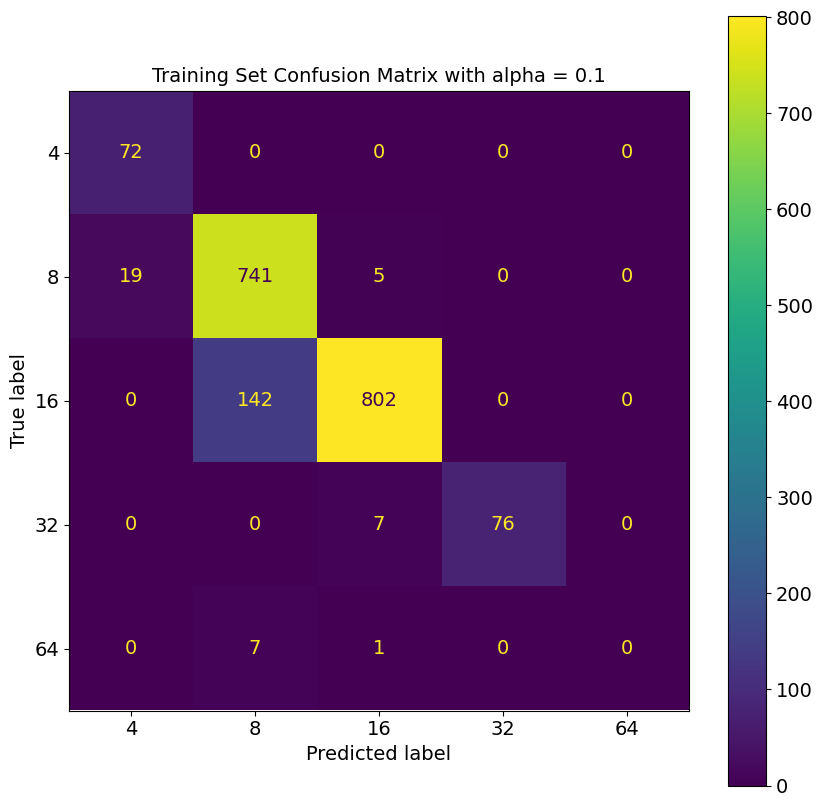

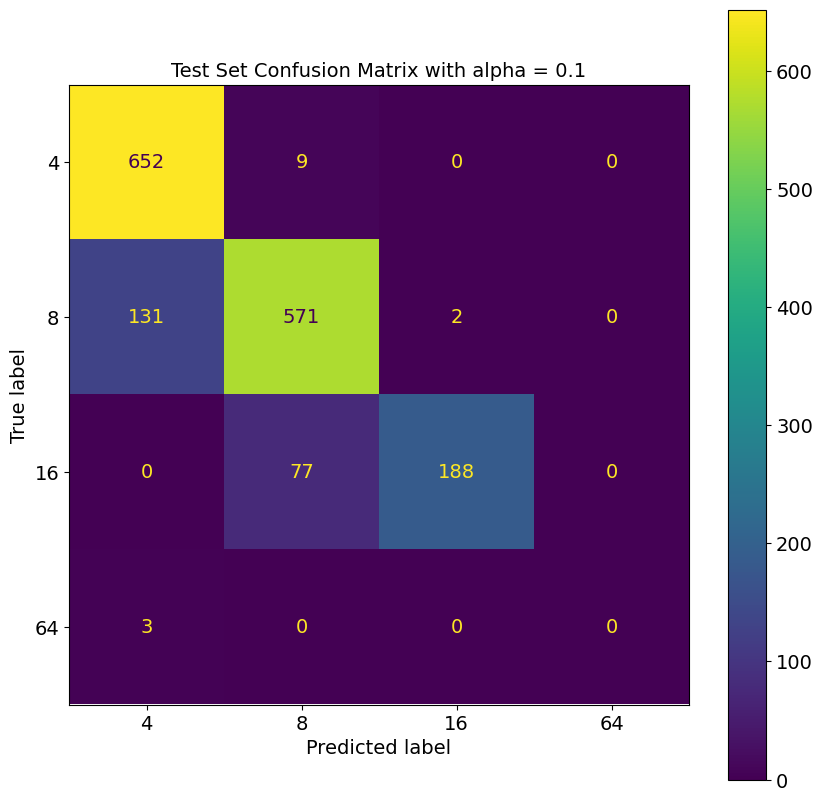

In [ ]:
# Display confusion matrix for test set
fig, ax = plt.subplots(figsize=(10, 10));
ConfusionMatrixDisplay.from_predictions(MF_train_TL_DA, MF_reg_predicted_train_TL_DA, ax = ax);
plt.title("Training Set Confusion Matrix with alpha = {}".format(alpha))
plt.show()

# Display confusion matrix for test set
fig, ax = plt.subplots(figsize=(10, 10));
ConfusionMatrixDisplay.from_predictions(MF_test_TL_DA, MF_reg_predicted_test_TL_DA, ax = ax);
plt.title("Test Set Confusion Matrix with alpha = {}".format(alpha))
plt.show()

## **4. CLASSIFICATION WITH DOMAIN ADAPTATION**

Train a Gradient Boosting Classifier (GBC) model using Transfer Learning with Domain Adaptation. In this case, the German dataset is used as training set (source domain) along with some points of the European dataset. The remaining points of the European dataset is used as test set (target domain).

### **4A. Tree Classification Model**

Convert the ground truth SNR values to ground truth modulation formats (MF), and call the function train_GBC() to train the model using as inputs the training features array and the new training labels (modulation formats) of the source domain and including the new data points of the target domain.

In [ ]:
# Convert ground truth SNR values to MF
MF_train_TL_DA, MF_test_TL_DA = convert_ground_truth(y_train_TL_DA, y_test_TL_DA)

# Convert of SNR list to an array
y_train_TL_DA_new = np.array(MF_train_TL_DA)
y_test_TL_DA_new = np.array(MF_test_TL_DA)

# Train the GBC model
t0 = time.time()
GBC_TL_DA = train_GBC(X_train_TL_DA, y_train_TL_DA_new)
t1 = time.time()

# Get the training time
training_time_GBC_TL_DA = round(t1-t0, 3)

print('Training time [s]: ' + str(training_time_GBC_TL_DA))

Training time [s]: 24.488


### **4B. Performance Metrics Evaluation**

Display the performance metrics for training and test sets.

In [ ]:
# PERFORMANCE METRICS EVALUATION

# Predict the output labels for the training and test sets
yhat_GBC_train_TL_DA = GBC_TL_DA.predict(X_train_TL_DA)
yhat_GBC_test_TL_DA = GBC_TL_DA.predict(X_test_TL_DA)

# Compute the performance metrics for the training set
accuracy_train_TL_DA = accuracy_score(y_train_TL_DA_new, yhat_GBC_train_TL_DA)
precision_train_TL_DA = precision_score(y_train_TL_DA_new, yhat_GBC_train_TL_DA, average = 'weighted')
recall_train_TL_DA = recall_score(y_train_TL_DA_new, yhat_GBC_train_TL_DA, average = 'weighted')
f1_train_TL_DA = f1_score(y_train_TL_DA_new, yhat_GBC_train_TL_DA, average = 'weighted')

# Print the performance metrics for the training set
print('\n********** TRAINING SCORES **********\n')
print('Gradient Boosting Classification - Transfer Learning with Domain Adaptation')
print('Final training accuracy score is: ' + str(round(accuracy_train_TL_DA, 3)))
print('Final training precision score is: ' + str(round(precision_train_TL_DA, 3)))
print('Final training recall score is: ' + str(round(recall_train_TL_DA, 3)))
print('Final training F1 score is: ' + str(round(f1_train_TL_DA, 3)))

# Compute the performance metrics for the test set
accuracy_test_TL_DA = accuracy_score(y_test_TL_DA_new, yhat_GBC_test_TL_DA)
precision_test_TL_DA = precision_score(y_test_TL_DA_new, yhat_GBC_test_TL_DA, average = 'weighted')
recall_test_TL_DA = recall_score(y_test_TL_DA_new, yhat_GBC_test_TL_DA, average = 'weighted')
f1_test_TL_DA = f1_score(y_test_TL_DA_new, yhat_GBC_test_TL_DA, average = 'weighted')

# Print the performance metrics for the test set
print('\n********** TEST SCORES **************\n')
print('Gradient Boosting Classification - Transfer Learning with Domain Adaptation')
print('Final test accuracy score is: ' + str(round(accuracy_test_TL_DA, 3)))
print('Final test precision score is: ' + str(round(precision_test_TL_DA, 3)))
print('Final test recall score is: ' + str(round(recall_test_TL_DA, 3)))
print('Final test F1 score is: ' + str(round(f1_test_TL_DA, 3)))


********** TRAINING SCORES **********

Gradient Boosting Classification - Transfer Learning with Domain Adaptation
Final training accuracy score is: 0.941
Final training precision score is: 0.937
Final training recall score is: 0.941
Final training F1 score is: 0.939

********** TEST SCORES **************

Gradient Boosting Classification - Transfer Learning with Domain Adaptation
Final test accuracy score is: 0.906
Final test precision score is: 0.905
Final test recall score is: 0.906
Final test F1 score is: 0.905


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **4C. Overestimations and Underestimations for Training and Test Sets**

Compute the Modulation Format (MF) overestimations and underestimations to evaluate the overall performance of the Transfer Learning with Domain Adaptation approach.

In [ ]:
# Compute the number of over/under-estimations for the training set
num_overrated_MF_train_GBC_TL_DA = np.count_nonzero(y_train_TL_DA_new < yhat_GBC_train_TL_DA)
num_underrated_MF_train_GBC_TL_DA = np.count_nonzero(y_train_TL_DA_new > yhat_GBC_train_TL_DA)
num_incorrect_MF_train_GBC_TL_DA = num_overrated_MF_train_GBC_TL_DA + num_underrated_MF_train_GBC_TL_DA
num_total_MF_train_TL_DA = len(y_train_TL_DA_new)
percentage_incorrect_MF_train_GBC_TL_DA = round(100*(num_incorrect_MF_train_GBC_TL_DA/num_total_MF_train_TL_DA), 3)

# Compute the number of over/under-estimations for the test set
num_overrated_MF_test_GBC_TL_DA = np.count_nonzero(y_test_TL_DA_new < yhat_GBC_test_TL_DA)
num_underrated_MF_test_GBC_TL_DA = np.count_nonzero(y_test_TL_DA_new > yhat_GBC_test_TL_DA)
num_incorrect_MF_test_GBC_TL_DA = num_overrated_MF_test_GBC_TL_DA + num_underrated_MF_test_GBC_TL_DA
num_total_MF_test_TL_DA = len(y_test_TL_DA_new)
percentage_incorrect_MF_test_GBC_TL_DA = round(100*(num_incorrect_MF_test_GBC_TL_DA/num_total_MF_test_TL_DA), 3)

# Display the incorrect MF assignments for the training set
print('******* TRAINING MF OVER/UNDER-ESTIMATIONS *******')
print('\nOut of {} MF assignments: '.format(num_total_MF_train_TL_DA))
print(' - Number of incorrectly-assigned MFs: {} ({} %)'.format(num_incorrect_MF_train_GBC_TL_DA, percentage_incorrect_MF_train_GBC_TL_DA))
print(' - Number of overrated MFs: {}'.format(num_overrated_MF_train_GBC_TL_DA))
print(' - Number of underrated MFs: {}'.format(num_underrated_MF_train_GBC_TL_DA))

# Display the incorrect MF assignments for the test set
print('\n********* TEST MF OVER/UNDER-ESTIMATIONS *********')
print('\nOut of {} MF assignments: '.format(num_total_MF_test_TL_DA))
print(' - Number of incorrectly-assigned MFs: {} ({} %)'.format(num_incorrect_MF_test_GBC_TL_DA, percentage_incorrect_MF_test_GBC_TL_DA))
print(' - Number of overrated MFs: {}'.format(num_overrated_MF_test_GBC_TL_DA))
print(' - Number of underrated MFs: {}'.format(num_underrated_MF_test_GBC_TL_DA))


******* TRAINING MF OVER/UNDER-ESTIMATIONS *******

Out of 1872 MF assignments: 
 - Number of incorrectly-assigned MFs: 111 (5.929 %)
 - Number of overrated MFs: 38
 - Number of underrated MFs: 73

********* TEST MF OVER/UNDER-ESTIMATIONS *********

Out of 1633 MF assignments: 
 - Number of incorrectly-assigned MFs: 153 (9.369 %)
 - Number of overrated MFs: 71
 - Number of underrated MFs: 82


### **4D. Display of Results**

Display the confusion matrices for the training and test sets using the corresponding arrays of ground truth and predicted modulation formats.

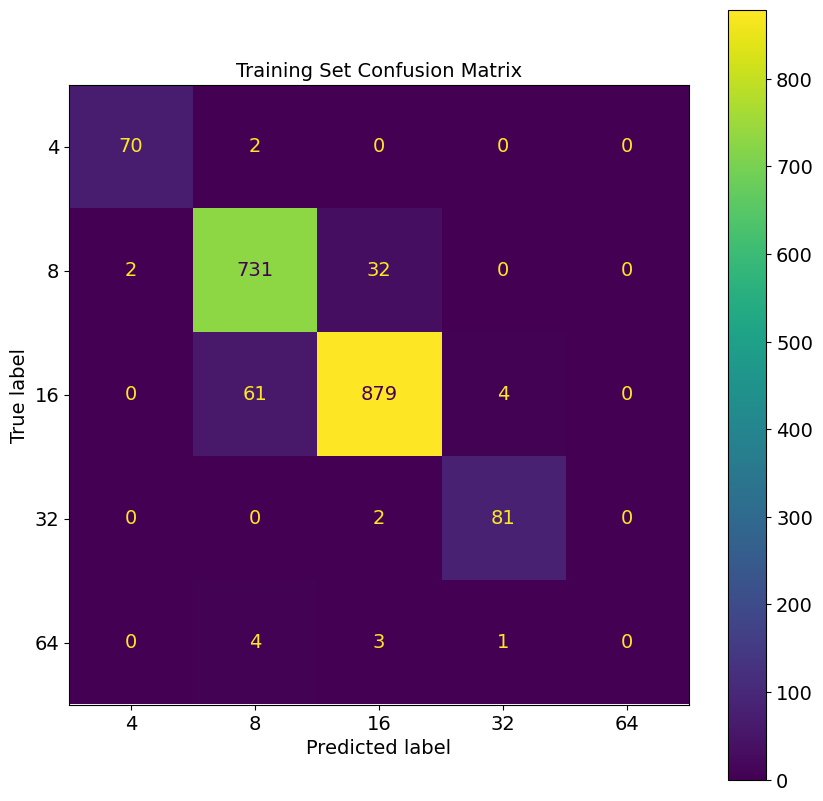

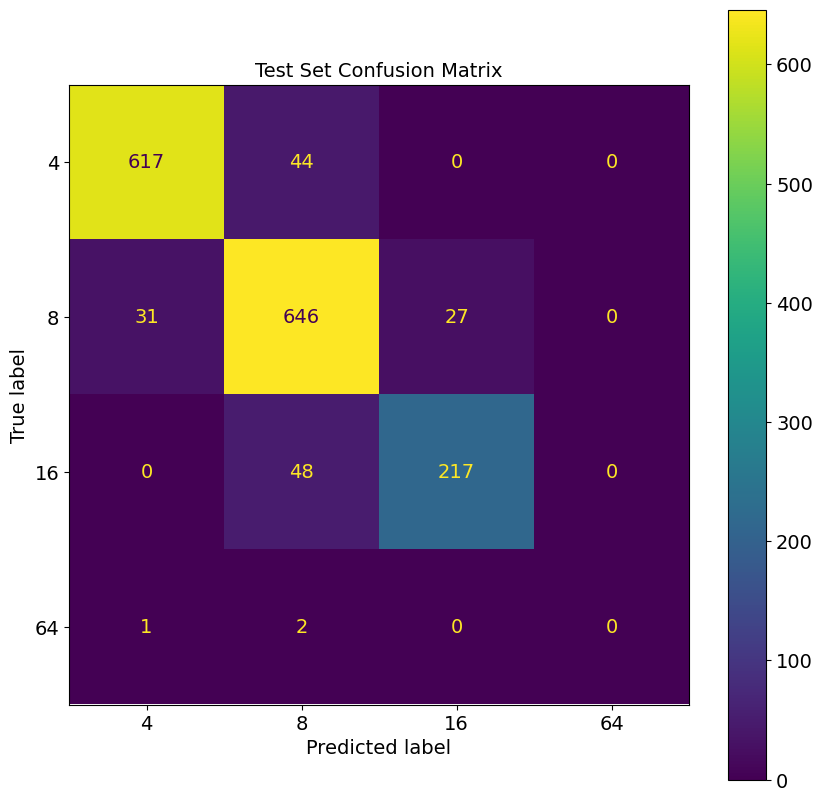

In [ ]:
# Predict the output labels for the training set
yhat_GBC_train_TL_DA = GBC_TL_DA.predict(X_train_TL_DA)

# Display confusion matrix for training set
fig, ax = plt.subplots(figsize=(10, 10));
ConfusionMatrixDisplay.from_predictions(y_train_TL_DA_new, yhat_GBC_train_TL_DA, ax = ax);
plt.title("Training Set Confusion Matrix")
plt.show()

# Predict the output labels for the test set
yhat_GBC_test_TL_DA = GBC_TL_DA.predict(X_test_TL_DA)

# Display confusion matrix for test set
fig, ax = plt.subplots(figsize=(10, 10));
ConfusionMatrixDisplay.from_predictions(y_test_TL_DA_new, yhat_GBC_test_TL_DA, ax = ax);
plt.title("Test Set Confusion Matrix")
plt.show()

# **IV. EXPLAINABLE AI (XAI)**

## **1. LIBRARIES IMPORTATION**

In [ ]:
# Install the specific version of the SHAP library
!pip install shap==0.42.1

# Import the SHAP library
import shap
import shap.plots

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 2.9 MB/s eta 0:00:00


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## **2. SHAP SUMMARY**

### **2A. Background Dataset Creation**

Assuming **GBC** as the trained Gradient Boosting Classifier and **X_train** is your training data, in this part it is created a background dataset to use it as input for *KernelExplainer* from *shap*.

Reference:
*   https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html


  0%|          | 0/1337 [00:00<?, ?it/s]

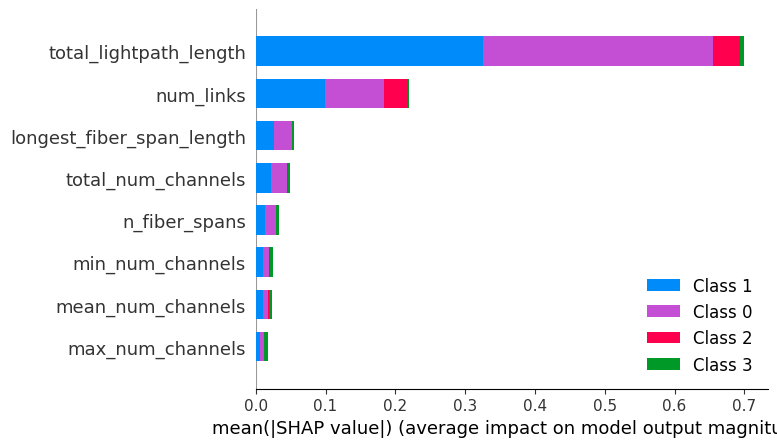

In [ ]:
# Assuming GBC is the trained GradientBoostingClassifier and X_train is your training data
# Create a background dataset for KernelExplainer (a subset of your training data)
background = shap.sample(X_train, 100)

# Set number of shap points to consider with SHAP, we can consider the whole dataset
shappoints = 2500

# Create the KernelExplainer
explainer_shap = shap.KernelExplainer(GBC.predict_proba, background)

# Calculate SHAP values
shap_values = explainer_shap.shap_values(X_train)

# Define the name of the features
feature_names = ['n_fiber_spans', 'total_lightpath_length', 'longest_fiber_span_length', 'max_num_channels', 'min_num_channels', 'mean_num_channels', 'num_links', 'total_num_channels']

# Plot SHAP values for a single prediction
shap.summary_plot(shap_values, X_train, feature_names)


In [ ]:
# Find the number of distinct labels and make a list of distinct labels for later use
n_label = len(set(y_train_new))
labels = list(set(y_train_new))

### **2B. Plot SHAP Summary**

Iterate over labels (classes) and plot the SHAP's summary plot of each label using the *summary_plot* method from *shap*. This method takes the **shap_values** of the class, data set (from this SHAP gets features' values) and features names in addition to the number of features to display.

Reference:
*   https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


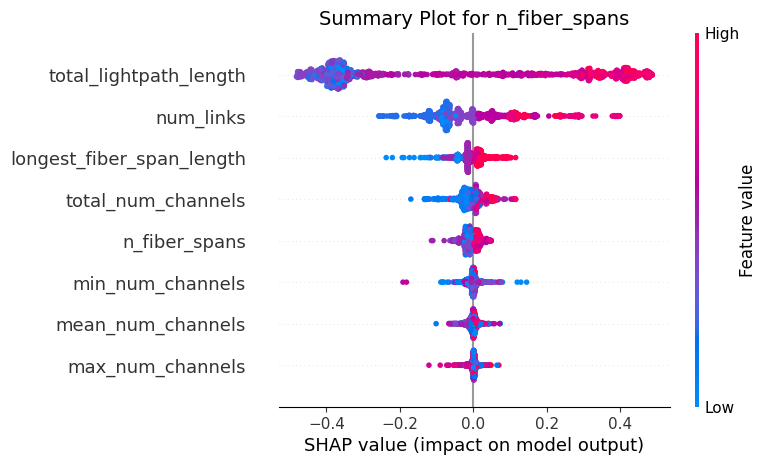

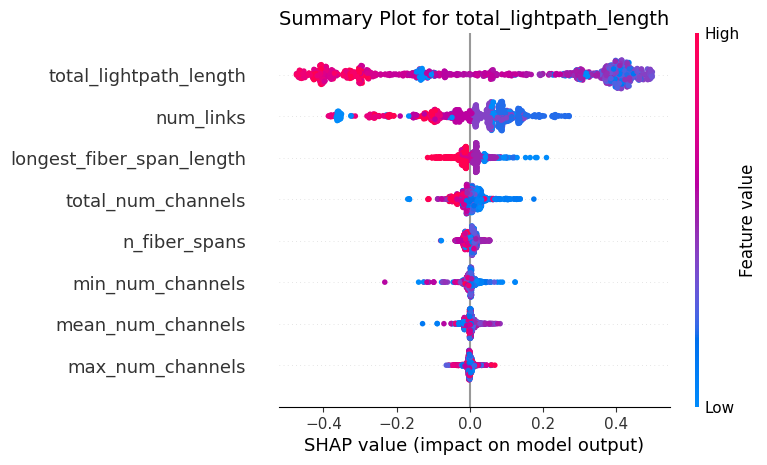

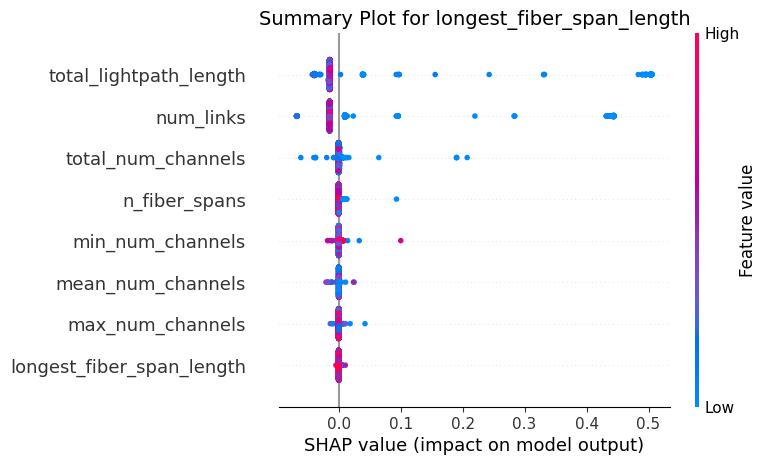

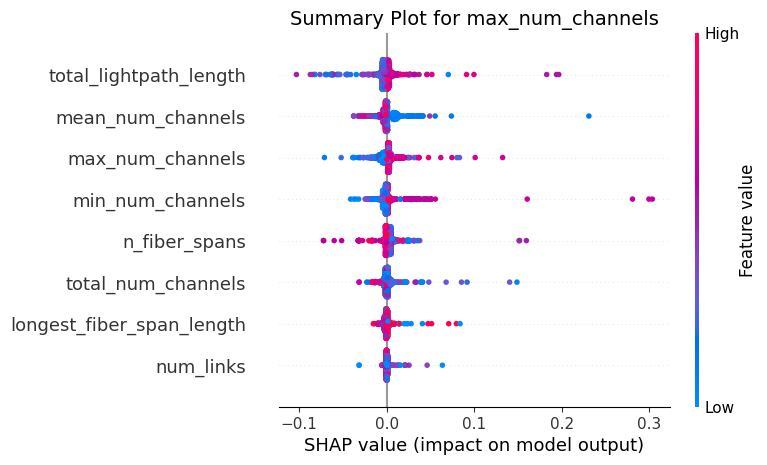

In [ ]:
# Define the class names and features names
class_name = labels
feature_names = ['n_fiber_spans', 'total_lightpath_length', 'longest_fiber_span_length', 'max_num_channels', 'min_num_channels', 'mean_num_channels', 'num_links', 'total_num_channels']

# Plot SHAP summary
for class_ind in range(n_label):
    shap.summary_plot(shap_values[class_ind], features = X_train[:shappoints], feature_names = feature_names, show = False, max_display = 10)

    title = 'Summary Plot for ' + str(feature_names[class_ind])
    plt.title(title)
    plt.show()


# **V. FURTHER ANALYSIS**

## **1. NORMALIZATION ANALYSIS**

* In this part of the code, we analyze the effect of omiting the normalization of the features that forms the dataset we used to train our GBR model.  
* We will get mean values of different parameters by training 10 times 2 GBR models: one that uses normalized features and other that uses features that have not been normalized.
* We will use these mean values to do a comparison on the performance of both models.

### **1A. Analysis of Size of the Range of the Features**
*   We start the analysis by calculating and displaying the range of each feature.
*   Our premise is that the model might become biased towards features with larger ranges.
*   We can see in the plot that the 2 features with bigger ranges by far are 'Lightpath length' and 'Total number of channels along the path'. Since these 2 features have high correlation (see SHAP Analysis) with the SNR (target variable), it suggests that the omission of the normalization won't drastically affect the overall performance of our GBR mode.

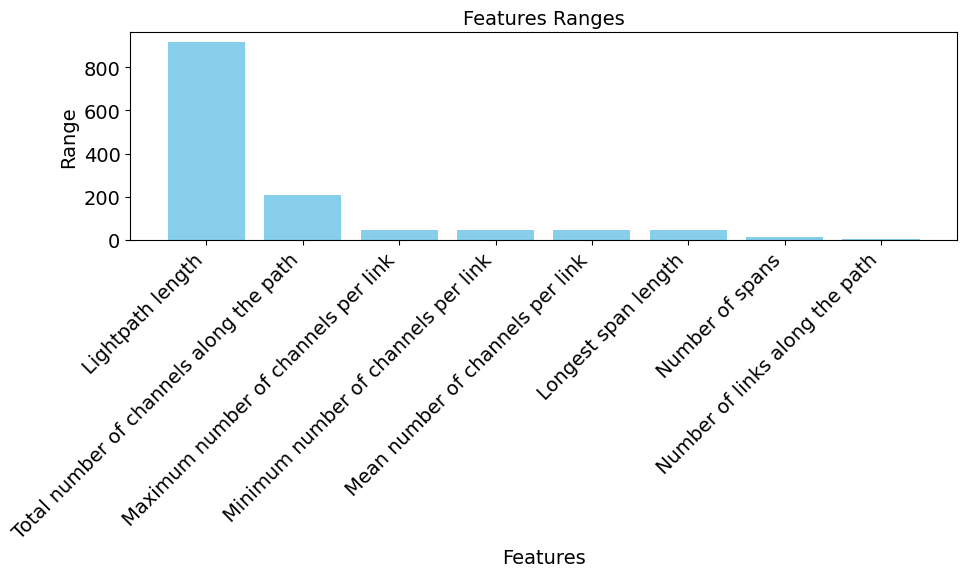

In [ ]:
# Function to calculate the range of a list
def calculate_range(lst):
    return max(lst) - min(lst)

# List to store the range for each feature
features_stats = []

# 1. Number of spans
range_ns = calculate_range(ns)
features_stats.append(['Number of spans', range_ns])

# 2. Lightpath (total span) length
range_ll = calculate_range(ll)
features_stats.append(['Lightpath length', range_ll])

# 3. Longest span length
range_ls = calculate_range(ls)
features_stats.append(['Longest span length', range_ls])

# 4. Maximum number of channels per link
ni_max = [X[i][3] for i in range(X.shape[0])]
range_ni_max = calculate_range(ni_max)
features_stats.append(['Maximum number of channels per link', range_ni_max])

# 5. Minimum number of channels per link
ni_min = [X[i][4] for i in range(X.shape[0])]
range_ni_min = calculate_range(ni_min)
features_stats.append(['Minimum number of channels per link', range_ni_min])

# 6. Mean number of channels per link
ni_mean = [X[i][5] for i in range(X.shape[0])]
range_ni_mean = calculate_range(ni_mean)
features_stats.append(['Mean number of channels per link', range_ni_mean])

# 7. Number of links along the path
ni_links = [X[i][6] for i in range(X.shape[0])]
range_ni_links = calculate_range(ni_links)
features_stats.append(['Number of links along the path', range_ni_links])

# 8. Total number of channels along the path
ni_total = [X[i][7] for i in range(X.shape[0])]
range_ni_total = calculate_range(ni_total)
features_stats.append(['Total number of channels along the path', range_ni_total])

# Features sorted based on the range in descending order
features_stats_sorted = sorted(features_stats, key=lambda x: x[1], reverse=True)

# Final matrix with the sorted features
final_matrix = np.array(features_stats_sorted)

# Plotting the features ranges
feature_names = final_matrix[:, 0]
feature_ranges = final_matrix[:, 1].astype(float)

plt.figure(figsize=(10, 6))
plt.bar(feature_names, feature_ranges, color='skyblue')
plt.xlabel('Features')
plt.ylabel('Range')
plt.title('Features Ranges')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### **1B. Function to plot Training Time of Both GBR Models**
* This function plots the duration of the training of 2 GBR models: one that was trained with a dataset with normalized features, and one that was trained with a dataset with features that have not been normalized.
* Respecting the training time, our premise is the following: training might take longer because the optimization algorithms might struggle to converge.

In [ ]:
def plot_training_time_comparison(train_duration, train_duration_wo_norm):
    # Round the metric values for training time
    train_duration_rounded = round(train_duration, 3)
    train_duration_rounded_wo_norm = round(train_duration_wo_norm, 3)

    # Labels for the metrics
    labels = ['Training Time']

    # Values with normalization
    values_with_norm = [train_duration_rounded]

    # Values without normalization
    values_wo_norm = [train_duration_rounded_wo_norm]

    # Setting the positions and width for the bars
    x = np.arange(len(labels))
    width = 0.35  # Width of the bars

    # Creating the plot
    fig, ax = plt.subplots()

    bars_with_norm = ax.bar(x - width/2, values_with_norm, width, label='With Normalization')
    bars_wo_norm = ax.bar(x + width/2, values_wo_norm, width, label='Without Normalization')

    # Adding labels, title, and custom x-axis tick labels
    ax.set_xlabel(' ')
    ax.set_ylabel('Training time (s)')
    ax.set_title('Training Time Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    # Adding the values on top of the bars with a smaller font size
    ax.bar_label(bars_with_norm, padding=3, fontsize=9)
    ax.bar_label(bars_wo_norm, padding=3, fontsize=9)

    # Placing the legend outside the plot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)

    # Display the plot
    plt.tight_layout()
    plt.show()

### **1C. Function to plot Performance Metrics of Both GBR Models**
* This function was created to plot a figure where the performance metrics (R2 factor, MSE, MPL) of 2 different GBR models (one with normalized features and the other with features that haven't been normalized) are compared between each other.
* This function is used twice: one with the training sets, one with the test sets.
* Inputs: R2 factor, MSE and MPL of 2 different GBR models, title of the figure

In [ ]:
def plot_performance_comparison(r2_GBR_train, r2_GBR_train_wo_norm, mse_GBR_train, mse_GBR_train_wo_norm, mpl_GBR_train, mpl_GBR_train_wo_norm, title):
    # Define the metric values
    r2_train_rounded = round(r2_GBR_train, 3)
    r2_train_rounded_wo_norm = round(r2_GBR_train_wo_norm, 3)
    mse_train_rounded = round(mse_GBR_train, 3)
    mse_train_rounded_wo_norm = round(mse_GBR_train_wo_norm, 3)
    mpl_train_rounded = round(mpl_GBR_train, 3)
    mpl_train_rounded_wo_norm = round(mpl_GBR_train_wo_norm, 3)

    # Labels for the metrics
    labels = ['R2', 'MSE', 'MPL']

    # Values with normalization
    values_with_norm = [r2_train_rounded, mse_train_rounded, mpl_train_rounded]

    # Values without normalization
    values_wo_norm = [r2_train_rounded_wo_norm, mse_train_rounded_wo_norm, mpl_train_rounded_wo_norm]

    # Setting the positions and width for the bars
    x = np.arange(len(labels))
    width = 0.35

    # Creating the plot
    fig, ax = plt.subplots()

    bars_with_norm = ax.bar(x - width/2, values_with_norm, width, label='With Normalization')
    bars_wo_norm = ax.bar(x + width/2, values_wo_norm, width, label='Without Normalization')

    # Adding labels, title, and custom x-axis tick labels
    ax.set_xlabel(' ')
    ax.set_ylabel('Values')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    # Adding the values on top of the bars with a smaller font size
    ax.bar_label(bars_with_norm, padding=3, fontsize=9)
    ax.bar_label(bars_wo_norm, padding=3, fontsize=9)

    # Display the plot
    plt.tight_layout()
    plt.show()

### **1D. Supress print output Function**
* This function is used just to avoid printing the results for each iteration that we will have when training the GBR models.

In [ ]:
# Context manager to suppress stdout (it will be used to supress the printed output of train_GBR function )
@contextmanager
def suppress_stdout():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout

### **1E. Function to get the mean value of different performance parameters**
* Inputs of the function:
  * X_train, X_test
  * y_train, y_test
  * alpha
  * number of iterations
* Outputs:
  * Training time (Mean of the training times)
  * Performance metrics (Mean of the R2 factors for the training dataset, Mean of the MSEs for the training dataset, Mean of the MPLs for the training dataset,  Mean of the R2 factors for the test dataset, Mean of the MSEs for the test dataset, Mean of the MPLs for the test dataset)
  * SNR Over and under estimations (Mean of the percentages of overrated SNRs for the training dataset, Mean of the percentages of underrated SNRs for the training dataset, Mean of the percentages of overrated SNRs for the test dataset, Mean of the percentages of underrated SNRs for the test dataset)

In [ ]:
def evaluate_GBR(X_train_wo_norm, X_test_wo_norm, y_train, y_test, alpha_wo_norm, iterations):
    # Initialize lists to store results
    train_durations = []
    r2_train_scores = []
    mse_train_scores = []
    mpl_train_scores = []
    r2_test_scores = []
    mse_test_scores = []
    mpl_test_scores = []
    overrated_train_percentages = []
    underrated_train_percentages = []
    overrated_test_percentages = []
    underrated_test_percentages = []

    for _ in range(iterations):
        # Suppress the output of train_GBR
        with suppress_stdout():
            GBR_wo_norm, train_duration_wo_norm = train_GBR(X_train_wo_norm, y_train, alpha_wo_norm)

        # Store the training duration
        train_durations.append(train_duration_wo_norm)

        # Performance metrics evaluation for training set without normalization
        r2_GBR_train_wo_norm = GBR_wo_norm.score(X_train_wo_norm, y_train)
        yhat_GBR_train_wo_norm = GBR_wo_norm.predict(X_train_wo_norm)
        mse_GBR_train_wo_norm = mean_squared_error(y_train, yhat_GBR_train_wo_norm)
        mpl_GBR_train_wo_norm = mean_pinball_loss(y_train, yhat_GBR_train_wo_norm, alpha=alpha_wo_norm)

        # Store the training metrics
        r2_train_scores.append(r2_GBR_train_wo_norm)
        mse_train_scores.append(mse_GBR_train_wo_norm)
        mpl_train_scores.append(mpl_GBR_train_wo_norm)

        # Calculate overestimations and underestimations for training set
        delta_y_train_wo_norm = yhat_GBR_train_wo_norm - y_train
        delta_y_train_over_wo_norm = np.where(delta_y_train_wo_norm > 0)[0].tolist()
        delta_y_train_under_wo_norm = np.where(delta_y_train_wo_norm < 0)[0].tolist()

        total_SNR_train_wo_norm = len(delta_y_train_wo_norm)
        num_overrated_SNR_train_wo_norm = len(delta_y_train_over_wo_norm)
        num_underrated_SNR_train_wo_norm = len(delta_y_train_under_wo_norm)

        percentage_overrated_SNR_train_wo_norm = round(100*(num_overrated_SNR_train_wo_norm/total_SNR_train_wo_norm), 2)
        percentage_underrated_SNR_train_wo_norm = round(100*(num_underrated_SNR_train_wo_norm/total_SNR_train_wo_norm), 2)

        overrated_train_percentages.append(percentage_overrated_SNR_train_wo_norm)
        underrated_train_percentages.append(percentage_underrated_SNR_train_wo_norm)

        # Performance metrics evaluation for test set without normalization
        r2_GBR_test_wo_norm = GBR_wo_norm.score(X_test_wo_norm, y_test)
        yhat_GBR_test_wo_norm = GBR_wo_norm.predict(X_test_wo_norm)
        mse_GBR_test_wo_norm = mean_squared_error(y_test, yhat_GBR_test_wo_norm)
        mpl_GBR_test_wo_norm = mean_pinball_loss(y_test, yhat_GBR_test_wo_norm, alpha=alpha_wo_norm)

        # Store the test metrics
        r2_test_scores.append(r2_GBR_test_wo_norm)
        mse_test_scores.append(mse_GBR_test_wo_norm)
        mpl_test_scores.append(mpl_GBR_test_wo_norm)

        # Calculate overestimations and underestimations for test set
        delta_y_test_wo_norm = yhat_GBR_test_wo_norm - y_test
        delta_y_test_over_wo_norm = np.where(delta_y_test_wo_norm > 0)[0].tolist()
        delta_y_test_under_wo_norm = np.where(delta_y_test_wo_norm < 0)[0].tolist()

        total_SNR_test_wo_norm = len(delta_y_test_wo_norm)
        num_overrated_SNR_test_wo_norm = len(delta_y_test_over_wo_norm)
        num_underrated_SNR_test_wo_norm = len(delta_y_test_under_wo_norm)

        percentage_overrated_SNR_test_wo_norm = round(100*(num_overrated_SNR_test_wo_norm/total_SNR_test_wo_norm), 2)
        percentage_underrated_SNR_test_wo_norm = round(100*(num_underrated_SNR_test_wo_norm/total_SNR_test_wo_norm), 2)

        overrated_test_percentages.append(percentage_overrated_SNR_test_wo_norm)
        underrated_test_percentages.append(percentage_underrated_SNR_test_wo_norm)

    # Calculate the mean of each metric
    mean_train_duration = np.mean(train_durations)
    mean_r2_train = np.mean(r2_train_scores)
    mean_mse_train = np.mean(mse_train_scores)
    mean_mpl_train = np.mean(mpl_train_scores)
    mean_r2_test = np.mean(r2_test_scores)
    mean_mse_test = np.mean(mse_test_scores)
    mean_mpl_test = np.mean(mpl_test_scores)
    mean_overrated_train_percentages = np.mean(overrated_train_percentages)
    mean_underrated_train_percentages = np.mean(underrated_train_percentages)
    mean_overrated_test_percentages = np.mean(overrated_test_percentages)
    mean_underrated_test_percentages = np.mean(underrated_test_percentages)

    return {
        "mean_train_duration": mean_train_duration,
        "mean_r2_train": mean_r2_train,
        "mean_mse_train": mean_mse_train,
        "mean_mpl_train": mean_mpl_train,
        "mean_r2_test": mean_r2_test,
        "mean_mse_test": mean_mse_test,
        "mean_mpl_test": mean_mpl_test,
        "mean_overrated_train_percentages": mean_overrated_train_percentages,
        "mean_underrated_train_percentages": mean_underrated_train_percentages,
        "mean_overrated_test_percentages": mean_overrated_test_percentages,
        "mean_underrated_test_percentages": mean_underrated_test_percentages
    }

### **1F. Analysis of GBR Model Performance with and without Features Normalization**
* In this part of the code we iterate 10 times over the training of 2 GBR models: one that uses normalized features and other that uses features that have not been normalized.
* We get from the functions mean values related to training time, performance metrics and over and under estimations of SNR (this will be used in the next section).
* We plot and compare training times and performance metrics of both GBR models.
* We check in the results that the training time of the model with features not normalized is slightly bigger than the one with normalized features.
* We also check that the performance metrics are almost identical.

In [ ]:
alpha_wo_norm = 0.1
results_norm = evaluate_GBR(X_train, X_test, y_train, y_test, alpha_wo_norm, iterations=10)
results_wo_norm = evaluate_GBR(X_train_wo_norm, X_test_wo_norm, y_train, y_test, alpha_wo_norm, iterations=10)

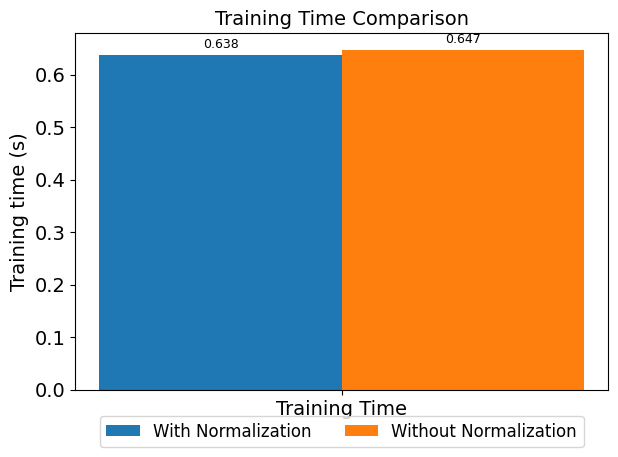

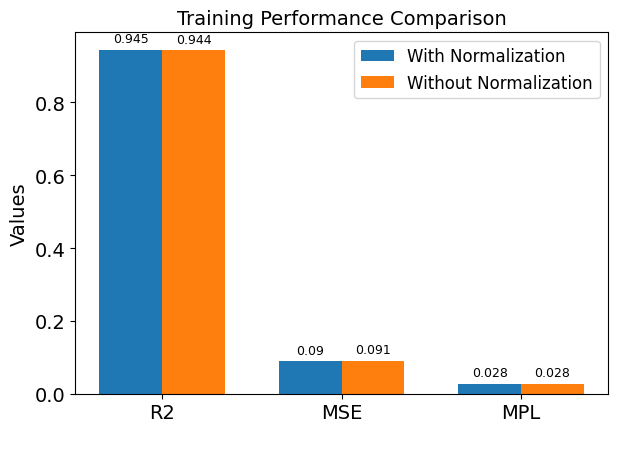

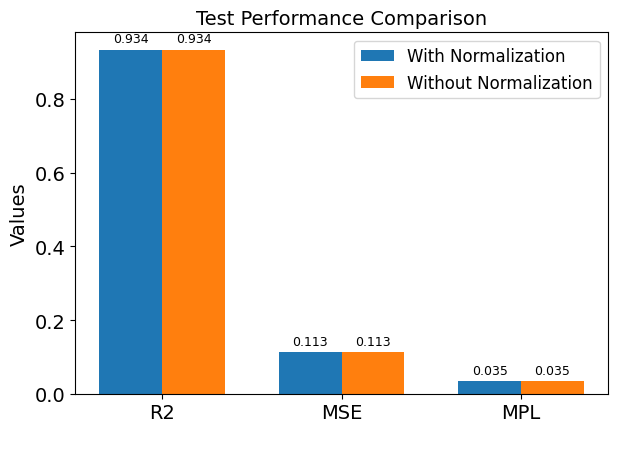

In [ ]:
plot_training_time_comparison(results_norm['mean_train_duration'], results_wo_norm['mean_train_duration'])

plot_performance_comparison(
    results_norm['mean_r2_train'], results_wo_norm['mean_r2_train'],
    results_norm['mean_mse_train'], results_wo_norm['mean_mse_train'],
    results_norm['mean_mpl_train'], results_wo_norm['mean_mpl_train'],
    'Training Performance Comparison'
)

plot_performance_comparison(
    results_norm['mean_r2_test'], results_wo_norm['mean_r2_test'],
    results_norm['mean_mse_test'], results_wo_norm['mean_mse_test'],
    results_norm['mean_mpl_test'], results_wo_norm['mean_mpl_test'],
    'Test Performance Comparison'
)

### **1G. Plot SNR Over/Under-estimations of Both GBR Models**
* This function was created to plot a figure where the over-estimations and under-estimations of the SNR level (target variable) of 2 different GBR models (one with normalized features and the other with features that haven't been normalized) are compared between each other.
* This function is used twice: one with the training sets, one with the test sets.
* Inputs: percentages of over-estimated and under-estimated SNR levels of 2 different GBR models, title of the figure

In [ ]:
def plot_estimations_comparison(percentage_overrated_SNR_train, percentage_overrated_SNR_train_wo_norm,
                        percentage_underrated_SNR_train, percentage_underrated_SNR_train_wo_norm, title):
    # Round the percentages
    overrated_SNR_train_rounded = round(percentage_overrated_SNR_train, 3)
    overrated_SNR_train_rounded_wo_norm = round(percentage_overrated_SNR_train_wo_norm, 3)
    underrated_SNR_train_rounded = round(percentage_underrated_SNR_train, 3)
    underrated_SNR_train_rounded_wo_norm = round(percentage_underrated_SNR_train_wo_norm, 3)

    # Labels
    labels = ['Overrated SNR', 'Underrated SNR']

    # Values with normalization
    values_with_norm = [overrated_SNR_train_rounded, underrated_SNR_train_rounded]

    # Values without normalization
    values_wo_norm = [overrated_SNR_train_rounded_wo_norm, underrated_SNR_train_rounded_wo_norm]

    # Setting the positions and width for the bars
    x = np.arange(len(labels))
    width = 0.35

    # Creating the plot
    fig, ax = plt.subplots()

    bars_with_norm = ax.bar(x - width/2, values_with_norm, width, label='With Normalization')
    bars_wo_norm = ax.bar(x + width/2, values_wo_norm, width, label='Without Normalization')

    # Adding labels, title, and custom x-axis tick labels
    ax.set_xlabel(' ')
    ax.set_ylabel('Percentage')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)

    # Adding the values on top of the bars
    ax.bar_label(bars_with_norm, padding=3, fontsize=9)
    ax.bar_label(bars_wo_norm, padding=3, fontsize=9)

    # Placing the legend outside the plot
    ax.legend(loc='upper left')

    # Display the plot
    plt.tight_layout()
    plt.show()

### **1H. Analysis of SNR Over/Under-estimations with and without Features Normalization**
* We conclude the analysis by extending the comparison to the mean values of the over-estimations and under-estimations of the SNR level (target variable) between the GBR model that uses normalized features with the GBR model that uses no normalized features.
* Over-estimations and under-estimations are expressed in percentage.
* This comparison is done for both training ant test datasets.
* We can check that the results are almost identical no matter if we are using normalized or not normalized features.

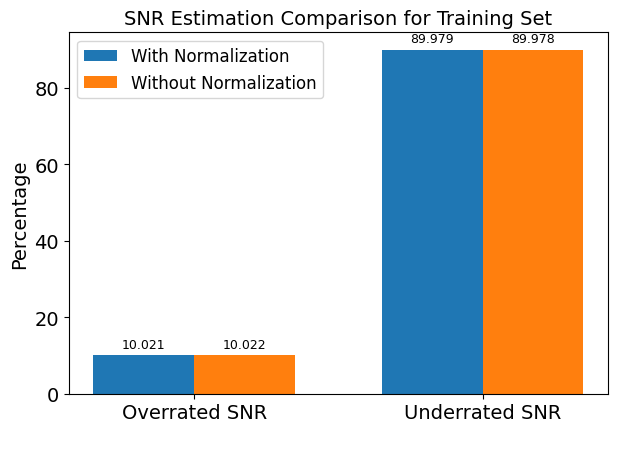

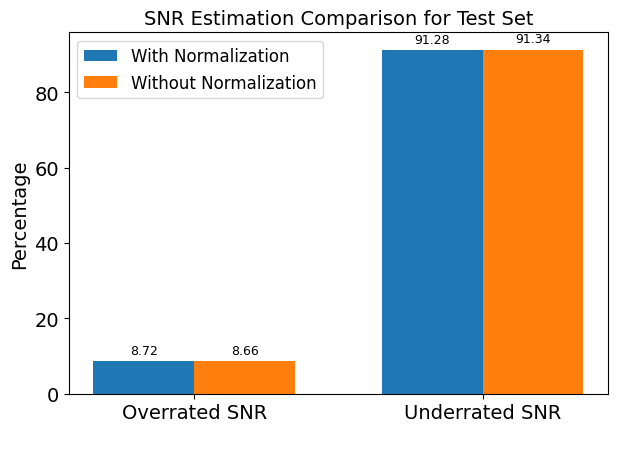

In [ ]:
#Plot of comparison of overestimations and underestimations for training set
plot_estimations_comparison(
    results_norm['mean_overrated_train_percentages'],
    results_wo_norm['mean_overrated_train_percentages'],
    results_norm['mean_underrated_train_percentages'],
    results_wo_norm['mean_underrated_train_percentages'],
    title='SNR Estimation Comparison for Training Set'
)

#Plot of comparison of overestimations and underestimations for test set
plot_estimations_comparison(
    results_norm['mean_overrated_test_percentages'],
    results_wo_norm['mean_overrated_test_percentages'],
    results_norm['mean_underrated_test_percentages'],
    results_wo_norm['mean_underrated_test_percentages'],
    title='SNR Estimation Comparison for Test Set'
)

## **2. BENCHMARK FULL TRAINING EUROPEAN DATASET**

### **2A. Dataset Definition**

In [ ]:
# DATASET DEFINITION

# Convert full European dataset into new X
X_benchmark = X_test_TL

# Convert of SNR list to an array
y_benchmark = y_test_TL

# Dataset split into training and test datasets
X_train_benchmark, X_test_benchmark, y_train_benchmark, y_test_benchmark = train_test_split(X_benchmark, y_benchmark, test_size = 0.2, shuffle = True, random_state = 0)

# Normalize the training and test datasets according to the training set statistics
scaler = StandardScaler()
X_train_benchmark = scaler.fit_transform(X_train_benchmark)
X_test_benchmark = scaler.transform(X_test_benchmark)

# Define a value of alpha
alpha = 0.10

# Call the function to train the model
GBR_benchmark, train_duration_benchmark = train_GBR(X_train_benchmark, y_train_benchmark, alpha)

Training time [s]: 1.424
Final training R2 score is: 0.948
Final training Mean Squared Error (MSE) is: 0.134
Final training Mean Pinball Loss (MPL) is: 0.035


### **2B. Performance Metrics Evaluation**

In [ ]:
# PERFORMANCE METRICS EVALUATION

# Performance metrics evaluation for test set
r2_GBR_test_benchmark = GBR_benchmark.score(X_test_benchmark, y_test_benchmark)
yhat_GBR_test_benchmark = GBR_benchmark.predict(X_test_benchmark)
mse_GBR_test_benchmark = mean_squared_error(y_test_benchmark, yhat_GBR_test_benchmark)
mpl_GBR_test_benchmark = mean_pinball_loss(y_test_benchmark, yhat_GBR_test_benchmark, alpha=alpha)

print('\n********** TEST SCORES **************')
print('Gradient Boosting Regression')
print('Final test R2 score is: ' + str(round(r2_GBR_test_benchmark, 3)))
print('Final test MSE is: ' + str(round(mse_GBR_test_benchmark, 3)))
print('Final test MPL is: ' + str(round(mpl_GBR_test_benchmark, 3)))


********** TEST SCORES **************
Gradient Boosting Regression
Final test R2 score is: 0.941
Final test MSE is: 0.152
Final test MPL is: 0.049


### **2C. Display of Results**


******* TEST MF OVER/UNDER-ESTIMATIONS *******

Out of 367 MF assignments: 
 - Number of incorrectly-assigned MFs: 49 (13.35 %)
 - Number of overrated MFs: 3
 - Number of underrated MFs: 46


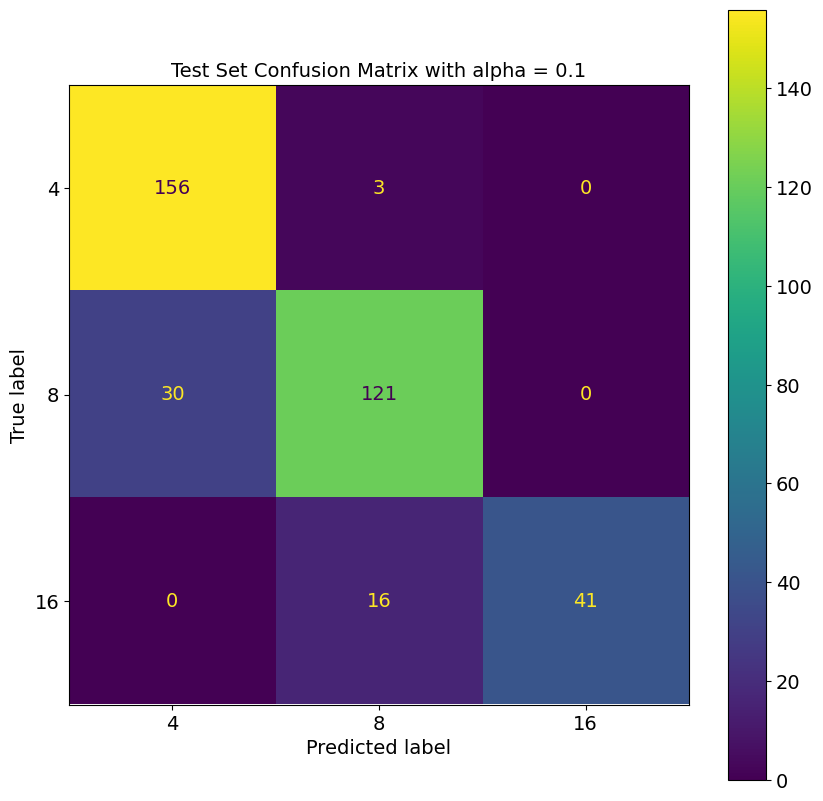

In [ ]:
# Compute the incorrect MF assignments for the test set
print('\n******* TEST MF OVER/UNDER-ESTIMATIONS *******')
MF_test_benchmark, MF_reg_predicted_test_benchmark, _ , _ , _ = find_MF_errors(y_test_benchmark, yhat_GBR_test_benchmark)

# Display confusion matrix for test set
fig, ax = plt.subplots(figsize=(10, 10));
ConfusionMatrixDisplay.from_predictions(MF_test_benchmark, MF_reg_predicted_test_benchmark, ax = ax);
plt.title("Test Set Confusion Matrix with alpha = {}".format(alpha))
plt.show()